<a href="https://colab.research.google.com/github/mm6396/ClusterComp/blob/main/evaluation_modulus8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Imports Section**


***New Expremiments; ***

In [223]:
#-------------------------------------------------------------------------------
#Method for Preprocessing datasetsand replacing nulls :
#-------------------------------------------------------------------------------

import pandas as pd
import os

def processing_procedure(files):
    processed_files = []
    for filename in files:

        df = pd.read_excel(filename, engine='openpyxl')

        
        df.interpolate(method='nearest', inplace=True, limit_direction='both')
        
        
        df.fillna(df.mean(), inplace=True)

        processed_filename = filename.split('.')[0] + '_processed.' + filename.split('.')[1]

        if os.path.exists(processed_filename):
            print(f"{processed_filename} already exists. Overwriting...")

       
        df.to_excel(processed_filename, index=False)

        processed_files.append(processed_filename)

    return processed_files



In [234]:
#-------------------------------------------------------------------------------
#------------GENERAL KEMENY YOUNG METHOD----------------------------------------
#-------------------------------------------------------------------------------


import numpy as np
from itertools import combinations, permutations



def kendalltau_dist(rank_a, rank_b):
    tau = 0
    n_candidates = len(rank_a)
    for i, j in combinations(range(n_candidates), 2):
        tau += (np.sign(rank_a[i] - rank_a[j]) ==
                -np.sign(rank_b[i] - rank_b[j]))
    return tau


def rankaggr_brute(ranks):
    min_dist = np.inf
    best_rank = None
    n_voters, n_candidates = ranks.shape
    for candidate_rank in permutations(range(n_candidates)):
        distances=[kendalltau_dist(candidate_rank, rank) for rank in ranks]
        dist = np.sum(distances)
        if dist < min_dist:
            min_dist = dist
            best_rank = candidate_rank
    return min_dist, best_rank


def print_rankings(dist, aggr,cols):
    print("A Kemeny-Young aggregation with score {} is:\n {}".format(
    dist,
    "\n ".join(cols[i] for i in np.argsort(aggr))))
    
    
def get_array_rankings(aggr, cols):
    rankings = [cols[i] for i in np.argsort(aggr)]
    return rankings


def parse_rankings(file_path):
    rankings = []
    cols=[]
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line:
                ranking_str = line.split(':')[1].strip()
                ranking_values = [col[1:-1] for col in ranking_str.split()]
                if cols==[]:
                    cols=ranking_values
                    rankings.append(list(range(1,len(ranking_values)+1)))
                else:
                    rankings.append([cols.index(temp) for temp in ranking_values])
    return np.array(rankings),cols



def KemenyRanking(file_path):
    # 1. Parse the rankings from the file.
    rankings, cols = parse_rankings(file_path)

    # 2. Compute the Kemeny-Young aggregation.
    _, best_rank = rankaggr_brute(rankings)

    # 3. Convert the aggregation to a list of labels (rankings).
    return get_array_rankings(best_rank, cols)




datasets/test1_processed.xlsx already exists. Overwriting...
datasets/test2_processed.xlsx already exists. Overwriting...
datasets/test3_processed.xlsx already exists. Overwriting...
datasets/test4_processed.xlsx already exists. Overwriting...


/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_8590/2130730272.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


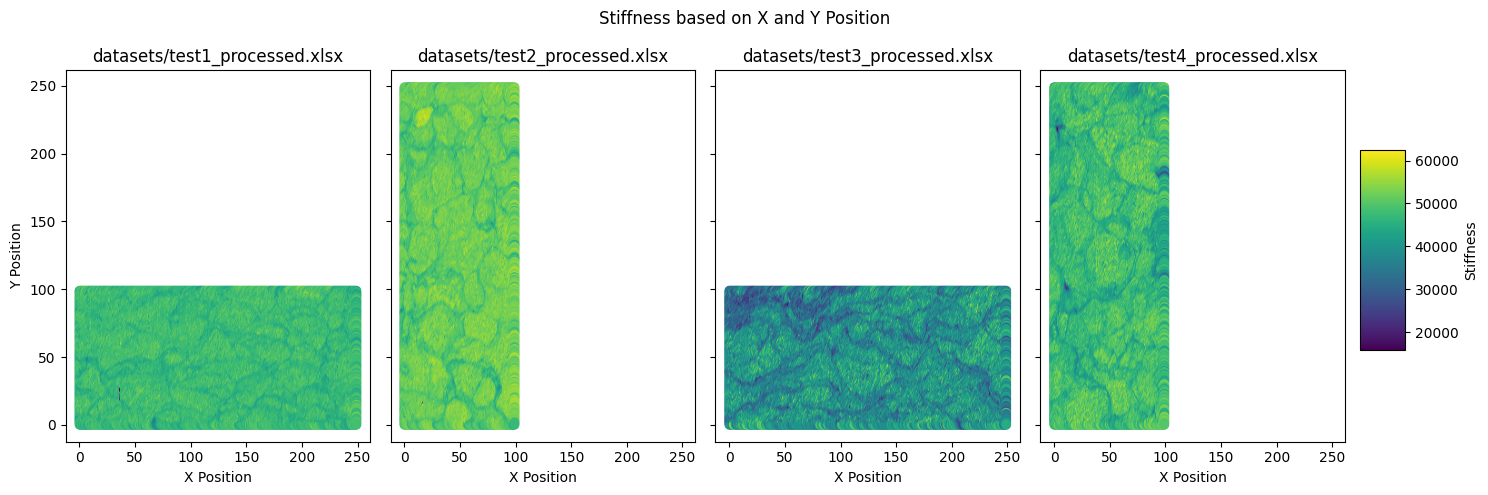

datasets/test1_processed.xlsx already exists. Overwriting...
datasets/test2_processed.xlsx already exists. Overwriting...
datasets/test3_processed.xlsx already exists. Overwriting...
datasets/test4_processed.xlsx already exists. Overwriting...


/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_8590/2130730272.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


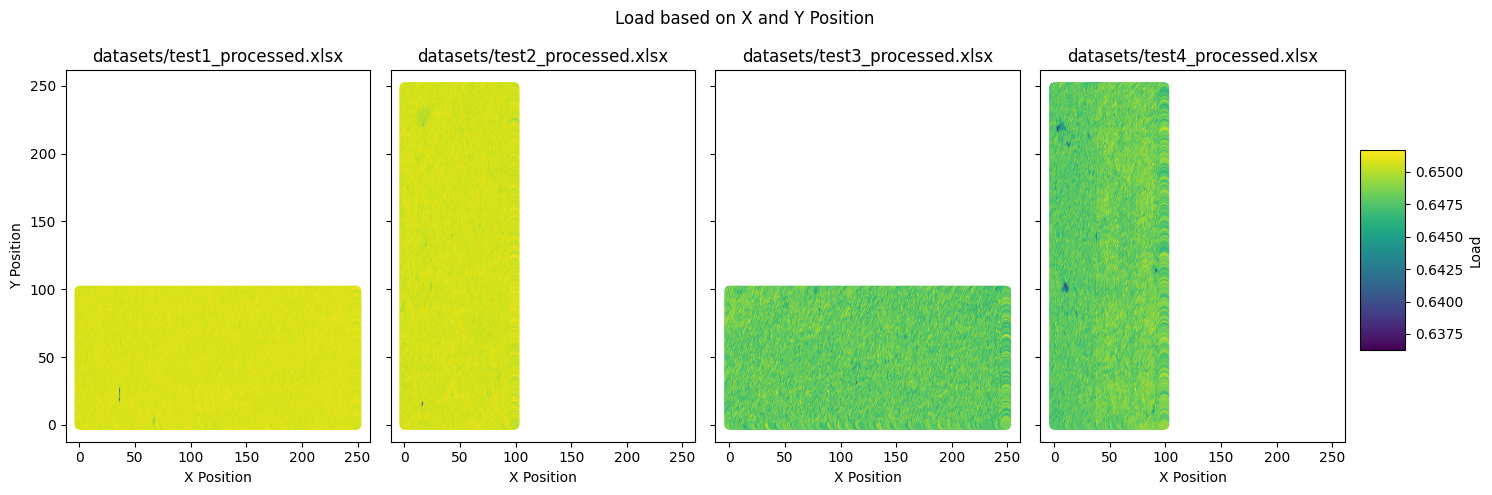

datasets/test1_processed.xlsx already exists. Overwriting...
datasets/test2_processed.xlsx already exists. Overwriting...
datasets/test3_processed.xlsx already exists. Overwriting...
datasets/test4_processed.xlsx already exists. Overwriting...


/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_8590/2130730272.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


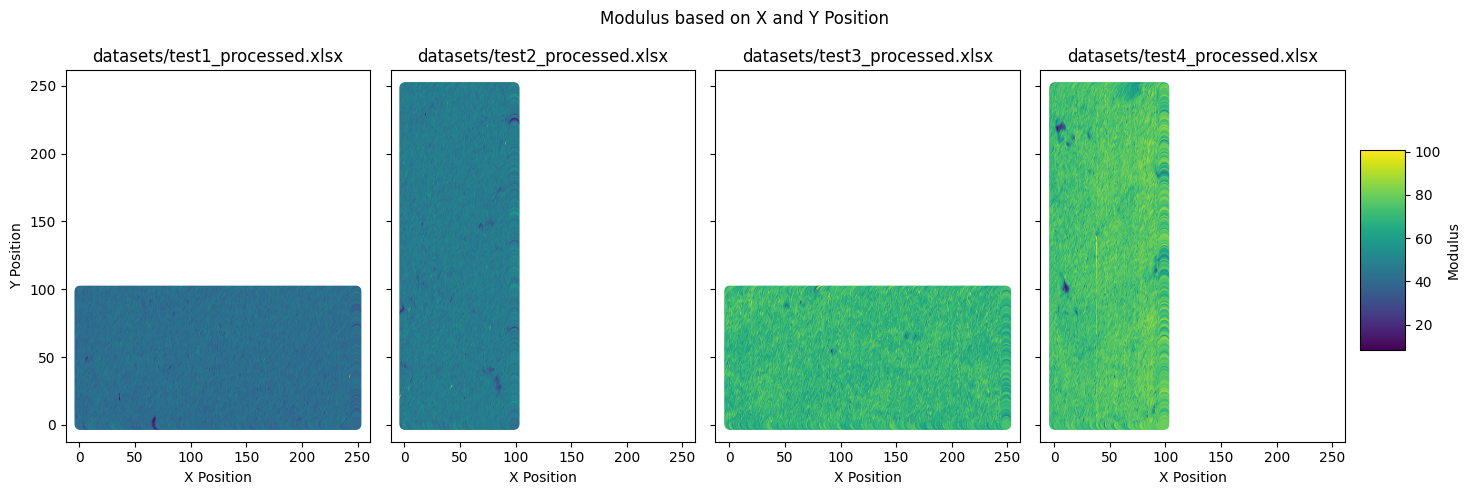

datasets/test1_processed.xlsx already exists. Overwriting...
datasets/test2_processed.xlsx already exists. Overwriting...
datasets/test3_processed.xlsx already exists. Overwriting...
datasets/test4_processed.xlsx already exists. Overwriting...


/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_8590/2130730272.py:127: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


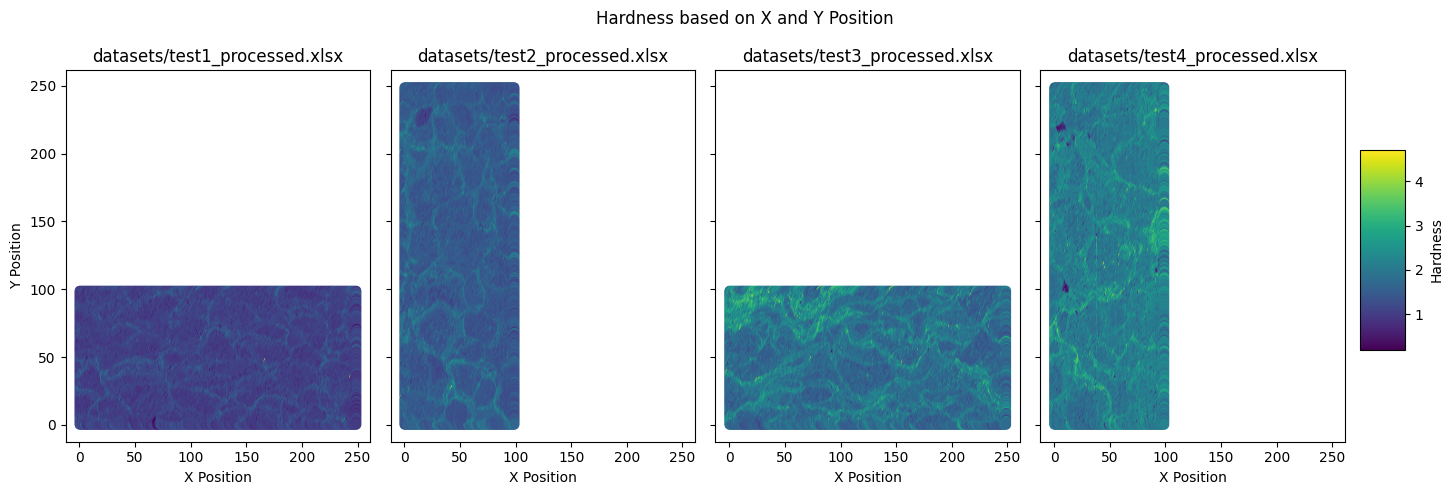

In [225]:
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Visulization Stifness based on X and Y positions
#-------------------------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt

files = ["datasets/test1.xlsx", "datasets/test2.xlsx", "datasets/test3.xlsx", "datasets/test4.xlsx"]
files_p = processing_procedure(files)

datasets = [pd.read_excel(file, engine='openpyxl') for file in files_p]

fig, axs = plt.subplots(1, len(datasets), figsize=(15, 5), sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for ax, df, file in zip(axs, datasets, files_p):
    sc = ax.scatter(df['X Position'], df['Y Position'], c=df['Stiffness'], cmap='viridis')
    ax.set_title(file)
    ax.set_xlabel('X Position')
    if ax == axs[0]:
        ax.set_ylabel('Y Position')

fig.colorbar(sc, cax=cbar_ax, label='Stiffness')
plt.suptitle('Stiffness based on X and Y Position')
plt.tight_layout()
plt.subplots_adjust(right=0.9)
plt.show()



#------------------------------------------------------------------------------
# visulization Load based on x and Y positions
#------------------------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt


files = ["datasets/test1.xlsx", "datasets/test2.xlsx", "datasets/test3.xlsx", "datasets/test4.xlsx"]

files_p = processing_procedure(files)



datasets = [pd.read_excel(file, engine='openpyxl') for file in files_p]


fig, axs = plt.subplots(1, len(datasets), figsize=(15, 5), sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for ax, df, file in zip(axs, datasets, files_p):
    sc = ax.scatter(df['X Position'], df['Y Position'], c=df['Load'], cmap='viridis')
    ax.set_title(file)
    ax.set_xlabel('X Position')
    if ax == axs[0]:
        ax.set_ylabel('Y Position')

fig.colorbar(sc, cax=cbar_ax, label='Load')

plt.suptitle('Load based on X and Y Position')
plt.tight_layout()
plt.subplots_adjust(right=0.9)
plt.show()



#-------------------------------------------------------------------------------
#Vitualization MODULUS based X and Y positions
#-------------------------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt


files = ["datasets/test1.xlsx", "datasets/test2.xlsx", "datasets/test3.xlsx", "datasets/test4.xlsx"]
files_p = processing_procedure(files)


datasets = [pd.read_excel(file, engine='openpyxl') for file in files_p]


fig, axs = plt.subplots(1, len(datasets), figsize=(15, 5), sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for ax, df, file in zip(axs, datasets, files_p):
    sc = ax.scatter(df['X Position'], df['Y Position'], c=df['MODULUS'], cmap='viridis')
    ax.set_title(file)
    ax.set_xlabel('X Position')
    if ax == axs[0]:
        ax.set_ylabel('Y Position')

fig.colorbar(sc, cax=cbar_ax, label='Modulus')

plt.suptitle('Modulus based on X and Y Position')
plt.tight_layout()
plt.subplots_adjust(right=0.9)
plt.show()


#-------------------------------------------------------------------------------
#Show HARDNESS based on X and Y positions
#-------------------------------------------------------------------------------


import pandas as pd
import matplotlib.pyplot as plt


files = ["datasets/test1.xlsx", "datasets/test2.xlsx", "datasets/test3.xlsx", "datasets/test4.xlsx"]
files_p = processing_procedure(files)


datasets = [pd.read_excel(file, engine='openpyxl') for file in files_p]


fig, axs = plt.subplots(1, len(datasets), figsize=(15, 5), sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for ax, df, file in zip(axs, datasets, files_p):
    sc = ax.scatter(df['X Position'], df['Y Position'], c=df['HARDNESS'], cmap='viridis')
    ax.set_title(file)
    ax.set_xlabel('X Position')
    if ax == axs[0]:
        ax.set_ylabel('Y Position')

fig.colorbar(sc, cax=cbar_ax, label='Hardness')

plt.suptitle('Hardness based on X and Y Position')
plt.tight_layout()
plt.subplots_adjust(right=0.9)
plt.show()

In [226]:
#------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#----------------Tuning parameters for "Agglomerative"-------------------------
#-------------------------------------------------------------------------------

import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Parameters grid
param_grid = {
    'n_clusters': [3],
    'affinity': ['euclidean', 'manhattan'],
    'linkage': ['ward', 'complete', 'average']
}

files = ["datasets/test1.xlsx", "datasets/test2.xlsx", "datasets/test3.xlsx", "datasets/test4.xlsx"]
files_p = processing_procedure(files)

columns_to_drop = ['Depth', 'X Position', 'Y Position', 'Z Position', 'Load', 'Stiffness', 'label']

eval_files = []


position_mapping = {
    0: 'X Position',  # test1
    1: 'Y Position',  # test2
    2: 'X Position',  # test3
    3: 'Y Position'   # test4
}


for idx, file in enumerate(files_p):
    if not os.path.exists("eval_datasets"):
        os.mkdir("eval_datasets")
    df = pd.read_excel(file, engine='openpyxl')
    position = position_mapping[idx]
    eval_data = df[df[position] < 125]
    eval_filename = "eval_datasets/" + f'test_{idx+1}_eval.xlsx'
    eval_data.to_excel(eval_filename, index=False)
    eval_files.append(eval_filename)

results = []


for eval_filename in eval_files:
    eval_df = pd.read_excel(eval_filename, engine='openpyxl')
    eval_df = eval_df.drop(columns=columns_to_drop, errors='ignore')
    scaled_eval = StandardScaler().fit_transform(eval_df)

    for n_clusters in param_grid['n_clusters']:
        for affinity in param_grid['affinity']:
            for linkage in param_grid['linkage']:
                if linkage == 'ward' and affinity != 'euclidean':
                    continue

                model = AgglomerativeClustering(n_clusters=n_clusters, affinity=affinity, linkage=linkage)
                labels = model.fit_predict(scaled_eval)
                
                silhouette_val = silhouette_score(scaled_eval, labels)
                calinski_val = calinski_harabasz_score(scaled_eval, labels)
                davies_val = davies_bouldin_score(scaled_eval, labels)

                results.append({
                    'file': eval_filename,
                    'n_clusters': n_clusters,
                    'affinity': affinity,
                    'linkage': linkage,
                    'silhouette_score': silhouette_val,
                    'calinski_harabasz_score': calinski_val,
                    'davies_bouldin_score': davies_val
                })

df_results = pd.DataFrame(results)

def concat_parameters(group):
    return ' '.join(group['parameters_combinations'].tolist())

df_results['parameters_combinations'] = df_results.iloc[:, 1:4].apply(lambda row: '"' + ','.join(row.dropna().astype(str)) + '"', axis=1)
df_results = df_results.drop(df_results.columns[1:4], axis=1)

if not os.path.exists("parameter_list"):
    os.mkdir("parameter_list")
output_file = "parameter_list/Agglomerative+parameterTuning.xlsx"
df_results.to_excel(output_file, index=False)

if not os.path.exists("rank_list"):
    os.mkdir("rank_list")

def write_ranked_parameters_to_file(df, metric, prefix):
    sorted_df = df.sort_values(by=metric, ascending=False if metric != "davies_bouldin_score" else True)
    grouped_combinations = sorted_df.groupby(['file']).apply(concat_parameters)
    with open('rank_list/tuning_list_agglomerative.txt', 'a') as f:
        i = 1
        for _, group_string in grouped_combinations.items():
            f.write(f'{prefix}{i} : {group_string}\n')
            i += 1


if os.path.exists('rank_list/tuning_list_agglomerative.txt'):
    os.remove('rank_list/tuning_list_agglomerative.txt')

write_ranked_parameters_to_file(df_results, 'silhouette_score', 'S')
write_ranked_parameters_to_file(df_results, 'calinski_harabasz_score', 'C')
write_ranked_parameters_to_file(df_results, 'davies_bouldin_score', 'D')

datasets/test1_processed.xlsx already exists. Overwriting...
datasets/test2_processed.xlsx already exists. Overwriting...
datasets/test3_processed.xlsx already exists. Overwriting...
datasets/test4_processed.xlsx already exists. Overwriting...


KeyboardInterrupt: 

In [ ]:
file_path = "rank_list/tuning_list_kemeny_agglomerative.txt" 
rankings,cols = parse_rankings(file_path)

dist, aggr = rankaggr_brute(rankings)

print_rankings(dist, aggr,cols)
Tuning_Agglo = get_array_rankings(aggr,cols)
print(Tuning_Agglo)



A Kemeny-Young aggregation with score 6 is:
 3,euclidean,average
 3,manhattan,complete
 3,manhattan,average
 3,euclidean,complete
 3,euclidean,ward
['3,euclidean,average', '3,manhattan,complete', '3,manhattan,average', '3,euclidean,complete', '3,euclidean,ward']


In [ ]:
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#----------------Tuning parameters for KMeans-----------------------------------
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------

import os
import pandas as pd
from itertools import product
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

param_grid_KMeans = {
    'n_clusters': [3],
    'init': ['k-means++', 'random'],
    'n_init': [10, 20, 30],
    'max_iter': [100, 200, 300]
}


param_combinations = list(product(param_grid_KMeans['n_clusters'],
                                  param_grid_KMeans['init'],
                                  param_grid_KMeans['n_init'],
                                  param_grid_KMeans['max_iter']))
param_dicts = [{'n_clusters': combo[0], 'init': combo[1], 'n_init': combo[2], 'max_iter': combo[3]} for combo in param_combinations]

files = ["datasets/test1.xlsx", "datasets/test2.xlsx", "datasets/test3.xlsx", "datasets/test4.xlsx"]
files_p = processing_procedure(files)

columns_to_drop = ['Depth', 'X Position', 'Y Position', 'Z Position', 'Load', 'Stiffness', 'label']

eval_files = []
tuning_files = []

position_mapping = {
    0: 'X Position',  # test1
    1: 'Y Position',  # test2
    2: 'X Position',  # test3
    3: 'Y Position'   # test4
}


for idx, file in enumerate(files_p):
    df = pd.read_excel(file, engine='openpyxl')
    position = position_mapping[idx]

    eval_data = df[df[position] < 125]
    eval_filename = os.path.join("eval_datasets", f'test_{idx+1}_eval.xlsx')
    if not os.path.exists(os.path.dirname(eval_filename)):
        os.mkdir(os.path.dirname(eval_filename))
    eval_data.to_excel(eval_filename, index=False)
    eval_files.append(eval_filename)

    tuning_data = df[df[position] > 125]
    tuning_filename = os.path.join("tuning_datasets", f'test_{idx+1}_tuning.xlsx')
    if not os.path.exists(os.path.dirname(tuning_filename)):
        os.mkdir(os.path.dirname(tuning_filename))
    tuning_data.to_excel(tuning_filename, index=False)
    tuning_files.append(tuning_filename)

results = []


for eval_filename in eval_files:
    eval_df = pd.read_excel(eval_filename, engine='openpyxl')
    eval_df = eval_df.drop(columns=columns_to_drop, errors='ignore')
    scaled_eval = StandardScaler().fit_transform(eval_df)

    for params in param_dicts:
        model = KMeans(**params) 
        labels = model.fit_predict(scaled_eval)

        silhouette_val = silhouette_score(scaled_eval, labels)
        calinski_val = calinski_harabasz_score(scaled_eval, labels)
        davies_val = davies_bouldin_score(scaled_eval, labels)

        results.append({
            'file': eval_filename,
            **params,  
            'silhouette_score': silhouette_val,
            'calinski_harabasz_score': calinski_val,
            'davies_bouldin_score': davies_val
        })

df_results = pd.DataFrame(results)

df_results['parameters_combinations'] = df_results.iloc[:, 1:5].apply(lambda row: '"' + ','.join(row.dropna().astype(str)) + '"', axis=1)
df_results = df_results.drop(df_results.columns[1:5], axis=1)

if not os.path.exists("parameter_list"):
    os.mkdir("parameter_list")
output_file = "parameter_list/Kmeans+parameterTuning.xlsx"
df_results.to_excel(output_file, index=False)

def concat_parameters(group):
    return ' '.join(group['parameters_combinations'].tolist())

def write_ranked_parameters_to_file(df, metric, prefix):
    sorted_df = df.sort_values(by=metric, ascending=False if metric != "davies_bouldin_score" else True)
    grouped_combinations = sorted_df.groupby(['file']).apply(concat_parameters)
    with open('rank_list/tuning_list_Kemeny_kmeans.txt', 'a') as f:
        i = 1
        for _, group_string in grouped_combinations.items():
            f.write(f'{prefix}{i} : {group_string}\n')
            i += 1


if os.path.exists('rank_list/tuning_list_Kemeny_kmeans.txt'):
    os.remove('rank_list/tuning_list_Kemeny_kmeans.txt')

write_ranked_parameters_to_file(df_results, 'silhouette_score', 'S')
write_ranked_parameters_to_file(df_results, 'calinski_harabasz_score', 'C')
write_ranked_parameters_to_file(df_results, 'davies_bouldin_score', 'D')



datasets/test1_processed.xlsx already exists. Overwriting...
datasets/test2_processed.xlsx already exists. Overwriting...
datasets/test3_processed.xlsx already exists. Overwriting...
datasets/test4_processed.xlsx already exists. Overwriting...


In [ ]:
#print(KemenyRanking('tuning_list_Kemeny_kmeans.txt').get_solution())
file_path = "rank_list/tuning_list_Kemeny_kmeans.txt" 
rankings,cols = parse_rankings(file_path)

dist, aggr = rankaggr_brute(rankings)

print_rankings(dist, aggr,cols)
#Kmeans_Aggregate = get_array_rankings(aggr,cols)
#print(Kmeans_Aggregate)

KeyboardInterrupt: 

In [ ]:
#-------------------------------------------------------------------------------
#Tuning parameters for DBSCAN
#-------------------------------------------------------------------------------
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN  # Import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

param_grid_DBSCAN = {
    'eps': [0.1, 0.2, 0.3],
    'min_samples': [5, 10, 15]
}

files = ["datasets/test1.xlsx", "datasets/test2.xlsx", "datasets/test3.xlsx", "datasets/test4.xlsx"]
files_p = processing_procedure(files)

columns_to_drop = ['Depth', 'X Position', 'Y Position', 'Z Position', 'Load', 'Stiffness', 'label']

eval_files = []
position_mapping = {
    0: 'X Position',
    1: 'Y Position',
    2: 'X Position',
    3: 'Y Position'
}

for idx, file in enumerate(files_p):
    if not os.path.exists("eval_datasets"):
        os.mkdir("eval_datasets")
    if not os.path.exists("tuning_datasets"):
        os.mkdir("tuning_datasets")

    df = pd.read_excel(file, engine='openpyxl')
    position = position_mapping[idx]
    eval_data = df[df[position] < 125]
    eval_filename = "eval_datasets/" + f'test_{idx+1}_eval.xlsx'
    eval_data.to_excel(eval_filename, index=False)
    eval_files.append(eval_filename)

    position = position_mapping[idx]
    tuning_data = df[df[position] > 125]
    tuning_filename = "tuning_datasets/" + f'test_{idx+1}_tuning.xlsx'
    tuning_data.to_excel(tuning_filename, index=False)

results = []

for eval_filename in eval_files:
    eval_df = pd.read_excel(eval_filename, engine='openpyxl')
    eval_df = eval_df.drop(columns=columns_to_drop, errors='ignore')
    scaled_eval = StandardScaler().fit_transform(eval_df)

    for eps in param_grid_DBSCAN['eps']:
        for min_samples in param_grid_DBSCAN['min_samples']:
            model = DBSCAN(eps=eps, min_samples=min_samples)
            labels = model.fit_predict(scaled_eval)
            core_samples_mask = labels != -1
            labels_core = labels[core_samples_mask]
            scaled_eval_core = scaled_eval[core_samples_mask]

            # Silhouette score is only meaningful if there's more than one cluster found
            if len(set(labels_core)) > 1:
                silhouette_val = silhouette_score(scaled_eval_core, labels_core)
                davies_val = davies_bouldin_score(scaled_eval_core, labels_core)
                calinski_val = calinski_harabasz_score(scaled_eval_core, labels_core)
            else:
                silhouette_val = -1
                davies_val = -1
                calinski_val = -1

            results.append({
                'file': eval_filename,
                'eps': eps,
                'min_samples': min_samples,
                'silhouette_score': silhouette_val,
                'calinski_harabasz_score': calinski_val,
                'davies_bouldin_score': davies_val
            })

df_results = pd.DataFrame(results)
df_results['parameters_combinations'] = df_results[['eps', 'min_samples']].apply(lambda row: '"' + ','.join(row.astype(str)) + '"', axis=1)

def concat_parameters(group):
    return ' '.join(group['parameters_combinations'].tolist())

def write_ranked_parameters_to_file(df, metric, prefix):
    sorted_df = df.sort_values(by=metric, ascending=False if metric != "davies_bouldin_score" else True)
    grouped_combinations = sorted_df.groupby(['file']).apply(concat_parameters)
    with open('rank_list/tuning_list_Kemeny_DBSCAN.txt', 'a') as f:
        i = 1
        for _, group_string in grouped_combinations.items():
            f.write(f'{prefix}{i} : {group_string}\n')
            i += 1

if os.path.exists('rank_list/tuning_list_Kemeny_DBSCAN.txt'):
    os.remove('rank_list/tuning_list_Kemeny_DBSCAN.txt')

write_ranked_parameters_to_file(df_results, 'silhouette_score', 'S')
write_ranked_parameters_to_file(df_results, 'calinski_harabasz_score', 'C')
write_ranked_parameters_to_file(df_results, 'davies_bouldin_score', 'D')



datasets/test1_processed.xlsx already exists. Overwriting...
datasets/test2_processed.xlsx already exists. Overwriting...
datasets/test3_processed.xlsx already exists. Overwriting...
datasets/test4_processed.xlsx already exists. Overwriting...


In [ ]:
#print(KemenyRanking('tuning_list_Kemeny_DBSCAN.txt').get_solution())
file_path = "rank_list/tuning_list_Kemeny_DBSCAN.txt" 
rankings,cols = parse_rankings(file_path)

dist, aggr = rankaggr_brute(rankings)

print_rankings(dist, aggr,cols)
#Kmeans_Aggregate = get_array_rankings(aggr,cols)
#print(Kmeans_Aggregate)

A Kemeny-Young aggregation with score 165 is:
 0.1,10.0
 0.2,15.0
 0.3,5.0
 0.1,15.0
 0.1,5.0
 0.2,10.0
 0.2,5.0
 0.3,15.0
 0.3,10.0


In [ ]:
#-------------------------------------------------------------------------------
#-----------------Tuning parameters for FCM-------------------------------------
#-------------------------------------------------------------------------------


import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from fcmeans import FCM
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

files = ["datasets/test1.xlsx", "datasets/test2.xlsx", "datasets/test3.xlsx", "datasets/test4.xlsx"]
files_p = processing_procedure(files)

columns_to_drop = ['Depth', 'X Position', 'Y Position', 'Z Position', 'Load', 'Stiffness' , 'label']

eval_files = []
tuning_files = []

position_mapping = {
    0: 'X Position',
    1: 'Y Position',
    2: 'X Position',
    3: 'Y Position'
}

for idx, file in enumerate(files_p):
    if not os.path.exists("eval_datasets"):
        os.mkdir("eval_datasets")

    if not os.path.exists("tuning_datasets"):
        os.mkdir("tuning_datasets")
    df = pd.read_excel(file, engine='openpyxl')

    position = position_mapping[idx]
    eval_data = df[df[position] < 125]

    eval_filename = "eval_datasets/" + f'test_{idx+1}_eval.xlsx'
    eval_data.to_excel(eval_filename, index=False)
    eval_files.append(eval_filename)

    position = position_mapping[idx]
    tuning_data = df[df[position] > 125]

    tuning_filename = "tuning_datasets/" + f'test_{idx+1}_tuning.xlsx'
    tuning_data.to_excel(tuning_filename, index=False)
    tuning_files.append(tuning_filename)

n_clusters_values = [3]
m_values = [1.1, 1.5, 2.0]

results = []

for eval_filename in eval_files:
    eval_df = pd.read_excel(eval_filename, engine='openpyxl')
    eval_df = eval_df.drop(columns=columns_to_drop, errors='ignore')
    scaled_data = StandardScaler().fit_transform(eval_df)

    for n_clusters in n_clusters_values:
        for m in m_values:
            fcm = FCM(n_clusters=n_clusters, m=m)
            fcm.fit(scaled_data)
            cluster_labels = fcm.predict(scaled_data)

            silhouette_val = silhouette_score(scaled_data, cluster_labels)
            calinski_val = calinski_harabasz_score(scaled_data, cluster_labels)
            davies_val = davies_bouldin_score(scaled_data, cluster_labels)

            results.append({
                'file': eval_filename,
                'n_clusters': n_clusters,
                'm': m,
                'silhouette_score': silhouette_val,
                'calinski_harabasz_score': calinski_val,
                'davies_bouldin_score': davies_val
            })

df_results = pd.DataFrame(results)

def concat_parameters(group):
    return ' '.join(group['parameters_combinations'].tolist())

df_results['parameters_combinations'] = df_results[['n_clusters', 'm']].apply(lambda row: '"' + ','.join(row.astype(str)) + '"', axis=1)

def write_ranked_parameters_to_file(df, metric, prefix):
    sorted_df = df.sort_values(by=metric, ascending=False if metric != "davies_bouldin_score" else True)
    grouped_combinations = sorted_df.groupby(['file']).apply(concat_parameters)
    with open('rank_list/tuning_list_Kemeny_FCM.txt', 'a') as f:
        i = 1
        for _, group_string in grouped_combinations.items():
            f.write(f'{prefix}{i} : {group_string}\n')
            i += 1

if not os.path.exists("parameter_list"):
    os.mkdir("parameter_list")

output_file = "parameter_list/FCM+parameterTuning.xlsx"
df_results.to_excel(output_file, index=False)

if not os.path.exists("rank_list"):
    os.mkdir("rank_list")

if os.path.exists('rank_list/tuning_list_Kemeny_FCM.txt'):
    os.remove('rank_list/tuning_list_Kemeny_FCM.txt')

write_ranked_parameters_to_file(df_results, 'silhouette_score', 'S')
write_ranked_parameters_to_file(df_results, 'calinski_harabasz_score', 'C')
write_ranked_parameters_to_file(df_results, 'davies_bouldin_score', 'D')

datasets/test1_processed.xlsx already exists. Overwriting...
datasets/test2_processed.xlsx already exists. Overwriting...
datasets/test3_processed.xlsx already exists. Overwriting...
datasets/test4_processed.xlsx already exists. Overwriting...


In [ ]:
#print(KemenyRanking('tuning_list_Kemeny_FCM.txt').get_solution())
file_path = "rank_list/tuning_list_Kemeny_FCM.txt" 
rankings,cols = parse_rankings(file_path)

dist, aggr = rankaggr_brute(rankings)

print_rankings(dist, aggr,cols)


A Kemeny-Young aggregation with score 0 is:
 3.0,1.1
 3.0,1.5
 3.0,2.0


In [ ]:
#-------------------------------------------------------------------------------
#---------------------------Tuning parameters for GMM --------------------------
#-------------------------------------------------------------------------------
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score




def concat_parameters(group):
    return ' '.join(group['parameters_combinations'].tolist())

files = ["datasets/test1.xlsx", "datasets/test2.xlsx", "datasets/test3.xlsx", "datasets/test4.xlsx"]
files_p = processing_procedure(files)

columns_to_drop = ['Depth', 'X Position', 'Y Position', 'Z Position', 'Load', 'Stiffness', 'label']
eval_files = []
tuning_files = []

position_mapping = {
    0: 'X Position', 
    1: 'Y Position',
    2: 'X Position', 
    3: 'Y Position'   
}

for idx, file in enumerate(files_p):
    if not os.path.exists("eval_datasets"):
        os.mkdir("eval_datasets")
    if not os.path.exists("tuning_datasets"):
        os.mkdir("tuning_datasets")
    df = pd.read_excel(file, engine='openpyxl')

    position = position_mapping[idx]
    eval_data = df[df[position] < 125]
    eval_filename = "eval_datasets/" + f'test_{idx+1}_eval.xlsx'
    eval_data.to_excel(eval_filename, index=False)
    eval_files.append(eval_filename)

    tuning_data = df[df[position] > 125]
    tuning_filename = "tuning_datasets/" + f'test_{idx+1}_tuning.xlsx'
    tuning_data.to_excel(tuning_filename, index=False)
    tuning_files.append(tuning_filename)

param_grid_GMM = {
    'n_components': [3],
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],
    'max_iter': [100, 200, 300]
}

results = []

for eval_filename in eval_files:
    eval_df = pd.read_excel(eval_filename, engine='openpyxl')
    eval_df = eval_df.drop(columns=columns_to_drop, errors='ignore')
    scaled_eval = StandardScaler().fit_transform(eval_df)

    for n_components in param_grid_GMM['n_components']:
        for covariance_type in param_grid_GMM['covariance_type']:
            for max_iter in param_grid_GMM['max_iter']:
                model = GaussianMixture(n_components=n_components, covariance_type=covariance_type, max_iter=max_iter)
                labels = model.fit_predict(scaled_eval)

                silhouette_val = silhouette_score(scaled_eval, labels)
                calinski_val = calinski_harabasz_score(scaled_eval, labels)
                davies_val = davies_bouldin_score(scaled_eval, labels)

                results.append({
                    'file': eval_filename,
                    'n_components': n_components,
                    'covariance_type': covariance_type,
                    'max_iter': max_iter,
                    'silhouette_score': silhouette_val,
                    'calinski_harabasz_score': calinski_val,
                    'davies_bouldin_score': davies_val
                })

df_results = pd.DataFrame(results)

def concat_parameters(group):
    return ' '.join(group['parameters_combinations'].tolist())

df_results['parameters_combinations'] = df_results[['n_components', 'covariance_type', 'max_iter']].apply(lambda row: '"' + ','.join(row.astype(str)) + '"', axis=1)

def write_ranked_parameters_to_file(df, metric, prefix):
    sorted_df = df.sort_values(by=metric, ascending=False if metric != "davies_bouldin_score" else True)
    grouped_combinations = sorted_df.groupby(['file']).apply(concat_parameters)
    with open('rank_list/tuning_list_Kemeny_GMM.txt', 'a') as f:
        i = 1
        for _, group_string in grouped_combinations.items():
            f.write(f'{prefix}{i} : {group_string}\n')
            i += 1

if not os.path.exists("parameter_list"):
    os.mkdir("parameter_list")

output_file = "parameter_list/GMM+parameterTuning.xlsx"
df_results.to_excel(output_file, index=False)

if not os.path.exists("rank_list"):
    os.mkdir("rank_list")

if os.path.exists('rank_list/tuning_list_Kemeny_GMM.txt'):
    os.remove('rank_list/tuning_list_Kemeny_GMM.txt')

write_ranked_parameters_to_file(df_results, 'silhouette_score', 'S')
write_ranked_parameters_to_file(df_results, 'calinski_harabasz_score', 'C')
write_ranked_parameters_to_file(df_results, 'davies_bouldin_score', 'D')

datasets/test1_processed.xlsx already exists. Overwriting...
datasets/test2_processed.xlsx already exists. Overwriting...
datasets/test3_processed.xlsx already exists. Overwriting...
datasets/test4_processed.xlsx already exists. Overwriting...


In [ ]:
#print(KemenyRanking('tuning_list_Kemeny_GMM.txt').get_solution())
file_path = "rank_list/tuning_list_Kemeny_GMM.txt" 
rankings,cols = parse_rankings(file_path)

dist, aggr = rankaggr_brute(rankings)

print_rankings(dist, aggr,cols)

KeyboardInterrupt: 

In [ ]:
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#-----------------------Tuning parameters for Kmedoids--------------------------
#-------------------------------------------------------------------------------

import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

files = ["datasets/test1.xlsx", "datasets/test2.xlsx", "datasets/test3.xlsx", "datasets/test4.xlsx"]
files_p = processing_procedure(files)

# Columns to be excluded
columns_to_drop = ['Depth', 'X Position', 'Y Position', 'Z Position', 'Load', 'Stiffness','label']

eval_files = []
tuning_files = []
       
position_mapping = {
    0: 'X Position',  # test1
    1: 'Y Position',  # test2
    2: 'X Position',  # test3
    3: 'Y Position'   # test4
}

for idx, file in enumerate(files_p):
    if not os.path.exists("eval_datasets"):
        os.mkdir("eval_datasets")

    if not os.path.exists("tuning_datasets"):
        os.mkdir("tuning_datasets")
    df = pd.read_excel(file, engine='openpyxl')


    position = position_mapping[idx]
    eval_data = df[df[position] < 125]

    eval_filename = "eval_datasets/" + f'test_{idx+1}_eval.xlsx'
    eval_data.to_excel(eval_filename, index=False)
    eval_files.append(eval_filename)

    position = position_mapping[idx]
    tuning_data = df[df[position] > 125]

    tuning_filename = "tuning_datasets/" +f'test_{idx+1}_tuning.xlsx'
    tuning_data.to_excel(tuning_filename, index=False)
    tuning_files.append(tuning_filename)

# KMedoids parameters
param_grid_KMedoids = {
    'n_clusters': [3],
    'init': ['random'],
    'max_iter': [100, 200, 300]
}
results = []

for eval_filename in eval_files:
    eval_df = pd.read_excel(eval_filename, engine='openpyxl')
    eval_df = eval_df.drop(columns=columns_to_drop, errors='ignore')
    scaled_eval = StandardScaler().fit_transform(eval_df)

    for n_clusters in param_grid_KMedoids['n_clusters']:
        for init in param_grid_KMedoids['init']:
            for max_iter in param_grid_KMedoids['max_iter']:
                # KMedoids clustering
                model = KMedoids(n_clusters=n_clusters, init=init, max_iter=max_iter)
                model.fit(scaled_eval)
                labels = model.labels_

                # Calculate scores
                silhouette = silhouette_score(scaled_eval, labels)
                calinski = calinski_harabasz_score(scaled_eval, labels)
                davies = davies_bouldin_score(scaled_eval, labels)

                # Append results to the list
                results.append({
                    'file': eval_filename,
                    'n_clusters': n_clusters,
                    'init': init,
                    'max_iter': max_iter,
                    'silhouette_score': silhouette,
                    'calinski_harabasz_score': calinski,
                    'davies_bouldin_score': davies
                })

df_results = pd.DataFrame(results)

def concat_parameters(group):
    return ' '.join(group['parameters_combinations'].tolist())

df_results['parameters_combinations'] = df_results[['n_clusters', 'init', 'max_iter']].apply(lambda row: '"' + ','.join(row.astype(str)) + '"', axis=1)

if not os.path.exists("parameter_list"):
    os.mkdir("parameter_list")

output_file = "parameter_list/Kmedoids+parameterTuning.xlsx"
df_results.to_excel(output_file, index=False)

if not os.path.exists("rank_list"):
    os.mkdir("rank_list")


def write_ranked_parameters_to_file(df, metric, prefix):
    sorted_df = df.sort_values(by=metric, ascending=False if metric != "davies_bouldin_score" else True)
    grouped_combinations = sorted_df.groupby(['file']).apply(concat_parameters)
    with open('rank_list/tuning_list_Kemeny_Kmedoids.txt', 'a') as f:  # Note the change in filename
        i = 1
        for _, group_string in grouped_combinations.items():
            f.write(f'{prefix}{i} : {group_string}\n')
            i += 1


if os.path.exists('rank_list/tuning_list_Kemeny_Kmedoids.txt'):
    os.remove('rank_list/tuning_list_Kemeny_Kmedoids.txt')

write_ranked_parameters_to_file(df_results, 'silhouette_score', 'S')
write_ranked_parameters_to_file(df_results, 'calinski_harabasz_score', 'C')
write_ranked_parameters_to_file(df_results, 'davies_bouldin_score', 'D')

datasets/test1_processed.xlsx already exists. Overwriting...
datasets/test2_processed.xlsx already exists. Overwriting...
datasets/test3_processed.xlsx already exists. Overwriting...
datasets/test4_processed.xlsx already exists. Overwriting...


In [ ]:
#print(KemenyRanking('tuning_list_Kemeny_Kmedoids.txt').get_solution())
file_path = "rank_list/tuning_list_Kemeny_Kmedoids.txt" 
rankings,cols = parse_rankings(file_path)

dist, aggr = rankaggr_brute(rankings)

print_rankings(dist, aggr,cols)

A Kemeny-Young aggregation with score 11 is:
 3,random,100
 3,random,200
 3,random,300


In [ ]:
#-------------------------------------------------------------------------------
#-----------------------Tuning parameters for OPTICS----------------------------
#-------------------------------------------------------------------------------
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
files = ["datasets/test1.xlsx", "datasets/test2.xlsx", "datasets/test3.xlsx", "datasets/test4.xlsx"]
files_p = processing_procedure(files)

# Columns to be excluded
columns_to_drop = ['Depth', 'X Position', 'Y Position', 'Z Position', 'Load', 'Stiffness', 'label']

eval_files = []
tuning_files = []

position_mapping = {
    0: 'X Position',  
    1: 'Y Position',  
    2: 'X Position',  
    3: 'Y Position'   
}

for idx, file in enumerate(files_p):
    if not os.path.exists("eval_datasets"):
        os.mkdir("eval_datasets")
    if not os.path.exists("tuning_datasets"):
        os.mkdir("tuning_datasets")

    df = pd.read_excel(file, engine='openpyxl')
    position = position_mapping[idx]
    eval_data = df[df[position] < 125]

    eval_filename = "eval_datasets/" + f'test_{idx+1}_eval.xlsx'
    eval_data.to_excel(eval_filename, index=False)
    eval_files.append(eval_filename)

    tuning_data = df[df[position] > 125]
    tuning_filename = "tuning_datasets/" + f'test_{idx+1}_tuning.xlsx'
    tuning_data.to_excel(tuning_filename, index=False)
    tuning_files.append(tuning_filename)

# OPTICS parameters
param_grid_OPTICS = {
    'min_samples': [3, 5],
    'xi': [0.05, 0.1, 0.2]
}

results = []
for eval_filename in eval_files:
    eval_df = pd.read_excel(eval_filename, engine='openpyxl')
    eval_df = eval_df.drop(columns=columns_to_drop, errors='ignore')
    scaled_eval = StandardScaler().fit_transform(eval_df)

    for min_samples in param_grid_OPTICS['min_samples']:
        for xi in param_grid_OPTICS['xi']:
            model = OPTICS(min_samples=min_samples, xi=xi)
            model.fit(scaled_eval)

            if len(set(model.labels_)) <= 1 or (len(set(model.labels_)) == 2 and -1 in model.labels_):
                continue

            labels = model.labels_
            silhouette = silhouette_score(scaled_eval, labels)
            calinski = calinski_harabasz_score(scaled_eval, labels)
            davies = davies_bouldin_score(scaled_eval, labels)

            results.append({
                'file': eval_filename,
                'min_samples': min_samples,
                'xi': xi,
                'silhouette_score': silhouette,
                'calinski_harabasz_score': calinski,
                'davies_bouldin_score': davies
            })


df_results = pd.DataFrame(results)

def concat_parameters(group):
    return ' '.join(group['parameters_combinations'].tolist())

df_results['parameters_combinations'] = df_results[['min_samples', 'xi']].apply(lambda row: '"' + ','.join(row.astype(str)) + '"', axis=1)


if not os.path.exists("parameter_list"):
    os.mkdir("parameter_list")
output_file = "parameter_list/OPTICS+parameterTuning.xlsx"
df_results.to_excel(output_file, index=False)


def write_ranked_parameters_to_file(df, metric, prefix):
    sorted_df = df.sort_values(by=metric, ascending=False if metric != "davies_bouldin_score" else True)
    grouped_combinations = sorted_df.groupby(['file']).apply(concat_parameters)
    with open('rank_list/tuning_list_Kemeny_OPTICS.txt', 'a') as f:
        i = 1
        for _, group_string in grouped_combinations.items():
            f.write(f'{prefix}{i} : {group_string}\n')
            i += 1


if not os.path.exists("rank_list"):
    os.mkdir("rank_list")


if os.path.exists('rank_list/tuning_list_Kemeny_OPTICS.txt'):
    os.remove('rank_list/tuning_list_Kemeny_OPTICS.txt')


write_ranked_parameters_to_file(df_results, 'silhouette_score', 'S')
write_ranked_parameters_to_file(df_results, 'calinski_harabasz_score', 'C')
write_ranked_parameters_to_file(df_results, 'davies_bouldin_score', 'D')


datasets/test1_processed.xlsx already exists. Overwriting...
datasets/test2_processed.xlsx already exists. Overwriting...
datasets/test3_processed.xlsx already exists. Overwriting...
datasets/test4_processed.xlsx already exists. Overwriting...


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_optics.py:903: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_optics.py:903: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_optics.py:903: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [ ]:
#print(KemenyRanking('tuning_list_Kemeny_OPTICS.txt').get_solution())


file_path = "rank_list/tuning_list_Kemeny_OPTICS.txt" 
rankings,cols = parse_rankings(file_path)

dist, aggr = rankaggr_brute(rankings)

print_rankings(dist, aggr,cols)

A Kemeny-Young aggregation with score 55 is:
 3.0,0.05
 3.0,0.1
 5.0,0.05
 3.0,0.2
 5.0,0.1
 5.0,0.2


In [ ]:
#-------------------------------------------------------------------------------
#-------------------   Tuning parameters for BIRCH  ----------------------------
#-------------------------------------------------------------------------------

import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

files = ["datasets/test1.xlsx", "datasets/test2.xlsx", "datasets/test3.xlsx", "datasets/test4.xlsx"]
files_p = processing_procedure(files)

columns_to_drop = ['Depth', 'X Position', 'Y Position', 'Z Position', 'Load', 'Stiffness', 'label']

eval_files = []

position_mapping = {
    0: 'X Position',  # test1
    1: 'Y Position',  # test2
    2: 'X Position',  # test3
    3: 'Y Position'   # test4
}

for idx, file in enumerate(files_p):
    if not os.path.exists("eval_datasets"):
        os.mkdir("eval_datasets")
    
    df = pd.read_excel(file, engine='openpyxl')
    position = position_mapping[idx]
    eval_data = df[df[position] < 125]
    eval_filename = "eval_datasets/" + f'test_{idx+1}_eval.xlsx'
    eval_data.to_excel(eval_filename, index=False)
    eval_files.append(eval_filename)

# BIRCH parameters
param_grid_BIRCH = {
    'n_clusters': [3],
    'threshold': [0.1, 0.2, 0.5],
    'branching_factor': [100, 200]
}

results = []

for eval_filename in eval_files:
    eval_df = pd.read_excel(eval_filename, engine='openpyxl')
    eval_df = eval_df.drop(columns=columns_to_drop, errors='ignore')
    scaled_eval = StandardScaler().fit_transform(eval_df)

    for n_clusters in param_grid_BIRCH['n_clusters']:
        for threshold in param_grid_BIRCH['threshold']:
            for branching_factor in param_grid_BIRCH['branching_factor']:
                model = Birch(n_clusters=n_clusters, threshold=threshold, branching_factor=branching_factor)
                model.fit(scaled_eval)
                labels = model.labels_

                results.append({
                    'file': eval_filename,
                    'n_clusters': n_clusters,
                    'threshold': threshold,
                    'branching_factor': branching_factor,
                    'silhouette_score': silhouette_score(scaled_eval, labels),
                    'calinski_harabasz_score': calinski_harabasz_score(scaled_eval, labels),
                    'davies_bouldin_score': davies_bouldin_score(scaled_eval, labels)
                })

df_results = pd.DataFrame(results)

def concat_parameters(group):
    return ' '.join(group['parameters_combinations'].tolist())

df_results['parameters_combinations'] = df_results[['n_clusters', 'threshold', 'branching_factor']].apply(lambda row: '"' + ','.join(row.astype(str)) + '"', axis=1)

if not os.path.exists("parameter_list"):
    os.mkdir("parameter_list")

output_file = "parameter_list/BIRCH+parameterTuning.xlsx"
df_results.to_excel(output_file, index=False)

def write_ranked_parameters_to_file(df, metric, prefix):
    sorted_df = df.sort_values(by=metric, ascending=False if metric != "davies_bouldin_score" else True)
    grouped_combinations = sorted_df.groupby(['file']).apply(concat_parameters)
    with open('rank_list/tuning_list_Kemeny_BIRCH.txt', 'a') as f:
        i = 1
        for _, group_string in grouped_combinations.items():
            f.write(f'{prefix}{i} : {group_string}\n')
            i += 1

if not os.path.exists("rank_list"):
    os.mkdir("rank_list")

if os.path.exists('rank_list/tuning_list_Kemeny_BIRCH.txt'):
    os.remove('rank_list/tuning_list_Kemeny_BIRCH.txt')

write_ranked_parameters_to_file(df_results, 'silhouette_score', 'S')
write_ranked_parameters_to_file(df_results, 'calinski_harabasz_score', 'C')
write_ranked_parameters_to_file(df_results, 'davies_bouldin_score', 'D')


datasets/test1_processed.xlsx already exists. Overwriting...
datasets/test2_processed.xlsx already exists. Overwriting...
datasets/test3_processed.xlsx already exists. Overwriting...
datasets/test4_processed.xlsx already exists. Overwriting...


In [ ]:
#print(KemenyRanking('tuning_list_Kemeny_BIRCH.txt').get_solution())
file_path = "rank_list/tuning_list_Kemeny_BIRCH.txt" 
rankings,cols = parse_rankings(file_path)

dist, aggr = rankaggr_brute(rankings)

print_rankings(dist, aggr,cols)

A Kemeny-Young aggregation with score 75 is:
 3.0,0.2,200.0
 3.0,0.1,200.0
 3.0,0.5,100.0
 3.0,0.5,200.0
 3.0,0.1,100.0
 3.0,0.2,100.0


Generating HMresults * in 4 steps

In [ ]:
#-------------------------------------------------------------------------------
# *********************** Generating HM-Scores (1) ********************************
#-------------------------------------------------------------------------------

import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, OPTICS, Birch
from sklearn_extra.cluster import KMedoids
from sklearn.mixture import GaussianMixture
from fcmeans import FCM
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


files_p = ["tuning_datasets/test_1_tuning.xlsx", "tuning_datasets/test_2_tuning.xlsx", "tuning_datasets/test_3_tuning.xlsx", "tuning_datasets/test_4_tuning.xlsx"]
#files_p = processing_procedure(files)
# EXCLUDE *******************************************************
columns_to_drop = ['Depth', 'X Position', 'Y Position', 'Z Position', 'Load', 'Stiffness' , 'label'] # please exclude those features that you dont need them
                                                                                           #First we do the expriments with Hardness alone and then Modulus Alone and then The combination of them
datasets = [pd.read_excel(file, engine='openpyxl').drop(columns_to_drop, axis=1, errors='ignore') for file in files_p]
scaled_datasets = [StandardScaler().fit_transform(df) for df in datasets]

clustering_algorithms = {
    'KMeans': KMeans(n_clusters=3, random_state=0 , init= 'k-means++' , n_init = 20 , max_iter = 100 ),

    'DBSCAN': DBSCAN(eps=0.2 , min_samples = 10),
    'Agglomerative': AgglomerativeClustering(n_clusters=3 , affinity = 'euclidean' ,  linkage = 'average'),
                     #linkage = {'ward' (default) , 'complete' , 'average' , 'single'}
                     #affinity= {'euclidean' , 'manhattan , 'cosine'}
    'OPTICS': OPTICS(min_samples = 3 , xi = 0.05),
    'KMedoids': KMedoids(n_clusters=3, random_state= 0 , init = 'random' , max_iter = 100),
                     #metric = {c , 'precomputed'}
    'GMM': GaussianMixture(n_components=3, max_iter=100 , covariance_type = 'tied'),
    'BIRCH': Birch(n_clusters=3 , branching_factor = 200 , threshold =0.2),

    'FCM': FCM(n_clusters=3 , m = 1.1)
}


metrics = {
    'Silhouette': silhouette_score,
    'Calinski-Harabasz': calinski_harabasz_score,
    'Davies-Bouldin': davies_bouldin_score
}

results = []

for index, (scaled_data, file_name) in enumerate(zip(scaled_datasets, files_p)):
    dataset_label = 'D' + str(index + 1)
    for algorithm_name, algorithm in clustering_algorithms.items():

        if algorithm_name == 'GMM':
            cluster_labels = algorithm.fit_predict(scaled_data)
        elif algorithm_name == 'FCM':
            algorithm.fit(scaled_data)
            cluster_labels = algorithm.u.argmax(axis=1)
        else:
            cluster_labels = algorithm.fit_predict(scaled_data)

        if len(set(cluster_labels)) > 1:
            for metric_name, metric_func in metrics.items():
                score = metric_func(scaled_data, cluster_labels)
                results.append({'Metric': metric_name,
                                'Dataset': dataset_label,
                                'Method': algorithm_name,
                                'Score': score})

results_df = pd.DataFrame(results)

# Reset the index to add 'Metric' and 'Dataset' as columns instead of multi-index
grouped = results_df.groupby(['Metric', 'Dataset', 'Method']).Score.mean().reset_index().pivot(index=['Metric', 'Dataset'], columns='Method', values='Score')
# Reset the multi-index and then set 'Dataset' as the new index
grouped = grouped.reset_index().set_index('Dataset')

if not os.path.exists("score_results"):
    os.mkdir("score_results")


if os.path.exists("score_results/HMresults.xlsx"):
    os.remove("score_results/HMresults.xlsx")

grouped.to_excel("score_results/HMresults.xlsx")
print(grouped.to_latex())









\begin{tabular}{llrrrrrrrr}
\toprule
Method &             Metric &  Agglomerative &        BIRCH &      DBSCAN &          FCM &          GMM &       KMeans &     KMedoids &     OPTICS \\
Dataset &                    &                &              &             &              &              &              &              &            \\
\midrule
D1      &  Calinski-Harabasz &     302.707577 &  5319.217753 &  131.442817 &  9305.011781 &  4458.944104 &  9305.094046 &  8998.792221 &  10.638527 \\
D2      &  Calinski-Harabasz &     221.243332 &  3530.791304 &  147.515811 &  7160.731394 &  3569.395160 &  7161.550342 &  6942.557392 &  10.607323 \\
D3      &  Calinski-Harabasz &     200.386318 &  6261.388738 &  205.489622 &  9808.895882 &  6669.548032 &  9808.183334 &  9657.315998 &   9.878291 \\
D4      &  Calinski-Harabasz &    1603.223039 &  3854.817044 &  278.568459 &  7546.419932 &  3586.827339 &  7547.239494 &  6942.174425 &  11.623450 \\
D1      &     Davies-Bouldin &       0.372257 &  

/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_8590/3717569216.py:84: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(grouped.to_latex())


In [ ]:
#------------------------------------------------------------------------
#-------------------------  HM_result step (2) -------------------------------------
#------------------------------------------------------------------------
import pandas as pd


df = pd.read_excel("score_results/HMresults.xlsx", engine='openpyxl')


clustering_methods = ['Agglomerative', 'BIRCH', 'DBSCAN', 'FCM', 'GMM', 'KMeans', 'KMedoids', 'OPTICS']

# Initialize an empty list to store rows and their corresponding rankings
interleaved_rows = []

for _, row in df.iterrows():
    # Append the original row first
    interleaved_rows.append(row)

    # Duplicate the row to assign rankings
    new_row = row.copy()
    new_row['Dataset'] = f"{row['Dataset']}_Ranking"

    # Depending on the metric, rank the clustering methods
    if row['Metric'] == 'Davies-Bouldin':
        rankings = row[clustering_methods].rank(ascending=True, method='first').astype(int)
    else:
        rankings = row[clustering_methods].rank(ascending=False, method='first').astype(int)

    new_row[clustering_methods] = rankings
    interleaved_rows.append(new_row)

# Convert the interleaved rows to a dataframe
rankings_df = pd.DataFrame(interleaved_rows)

# Save the updated results file
rankings_df.to_excel("score_results/HMresults2.xlsx", index=False)



df = pd.read_excel("score_results/HMresults2.xlsx")

# Convert the DataFrame to LaTeX format
latex_code = df.to_latex()

# Print the LaTeX code
print(latex_code)



\begin{tabular}{lllrrrrrrrr}
\toprule
{} &     Dataset &             Metric &  Agglomerative &        BIRCH &      DBSCAN &          FCM &          GMM &       KMeans &     KMedoids &     OPTICS \\
\midrule
0  &          D1 &  Calinski-Harabasz &     302.707577 &  5319.217753 &  131.442817 &  9305.011781 &  4458.944104 &  9305.094046 &  8998.792221 &  10.638527 \\
1  &  D1\_Ranking &  Calinski-Harabasz &       6.000000 &     4.000000 &    7.000000 &     2.000000 &     5.000000 &     1.000000 &     3.000000 &   8.000000 \\
2  &          D2 &  Calinski-Harabasz &     221.243332 &  3530.791304 &  147.515811 &  7160.731394 &  3569.395160 &  7161.550342 &  6942.557392 &  10.607323 \\
3  &  D2\_Ranking &  Calinski-Harabasz &       6.000000 &     5.000000 &    7.000000 &     2.000000 &     4.000000 &     1.000000 &     3.000000 &   8.000000 \\
4  &          D3 &  Calinski-Harabasz &     200.386318 &  6261.388738 &  205.489622 &  9808.895882 &  6669.548032 &  9808.183334 &  9657.315998 &   9.8

/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_8590/3826695766.py:43: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_code = df.to_latex()


In [ ]:
#-------------------------------------------------------------------------------
# ************************ generating HM-results (3) ***************************
#-------------------------------------------------------------------------------


import pandas as pd

results_df = pd.read_excel("score_results/HMresults2.xlsx", engine='openpyxl')


clustering_methods = ['Agglomerative', 'BIRCH', 'DBSCAN', 'FCM', 'GMM', 'KMeans', 'KMedoids', 'OPTICS']


ranking_rows = results_df[results_df['Dataset'].str.contains('_Ranking', na=False)]

# Dictionary to store ordered methods for each metric
ordered_methods_dict = {}

for metric in ranking_rows['Metric'].unique():
    metric_subset = ranking_rows[ranking_rows['Metric'] == metric]

    # Extract ranking order for each Dataset within the metric
    for _, row in metric_subset.iterrows():

        # Order clustering methods by their rank
        ordered_methods = [clustering_methods[i] for i in row[clustering_methods].argsort()]


        if metric in ordered_methods_dict:
            ordered_methods_dict[metric].append({row['Dataset']: ordered_methods})
        else:
            ordered_methods_dict[metric] = [{row['Dataset']: ordered_methods}]


for metric, datasets_order in ordered_methods_dict.items():
    with open(f"score_results/HMresult_{metric}.txt", 'w') as f:
        for order in datasets_order:
            dataset_name = list(order.keys())[0]
            
            
            methods_order = ' '.join(['"' + method + '"' for method in order[dataset_name]])
            
            f.write(f"{dataset_name}: {methods_order}\n")



# This give us an Aggregated_Ranking_Order across 4 datasets for each dataset /
# In the following we will plot the Barcharts based on the result of each Metrics







A Kemeny-Young aggregation with score 15 is:
 Agglomerative
 DBSCAN
 KMeans
 BIRCH
 FCM
 GMM
 KMedoids
 OPTICS
HM_DaviesBouldin: ['Agglomerative', 'GMM', 'BIRCH', 'KMeans', 'FCM', 'KMedoids', 'OPTICS', 'DBSCAN']
HM_Calinski_Harabasz: ['KMeans', 'FCM', 'KMedoids', 'BIRCH', 'GMM', 'Agglomerative', 'DBSCAN', 'OPTICS']
HM_Silhoute: ['Agglomerative', 'DBSCAN', 'KMeans', 'BIRCH', 'FCM', 'GMM', 'KMedoids', 'OPTICS']


/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_8590/3913133214.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(visual_rank.index, rotation=45, ha='right')
/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_8590/3913133214.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(visual_rank.index, rotation=45, ha='right')
/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_8590/3913133214.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(visual_rank.index, rotation=45, ha='right')


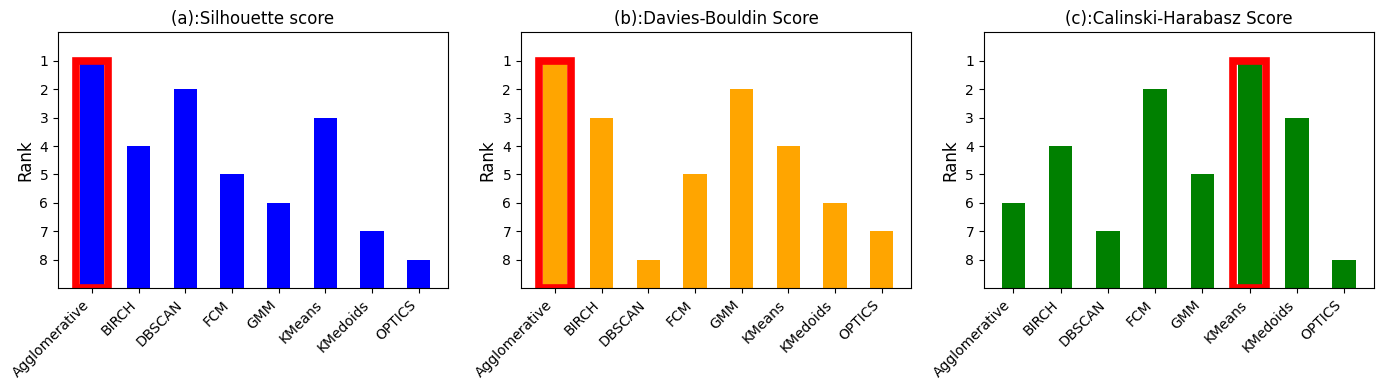

This is HM_final2 ['Agglomerative', 'BIRCH', 'DBSCAN', 'KMeans', 'FCM', 'GMM', 'KMedoids', 'OPTICS']
Agglomerative
['Agglomerative', 'BIRCH', 'DBSCAN', 'KMeans', 'FCM', 'GMM', 'KMedoids', 'OPTICS']


/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_8590/3913133214.py:129: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(visual_rank.index, rotation=45, ha='right')


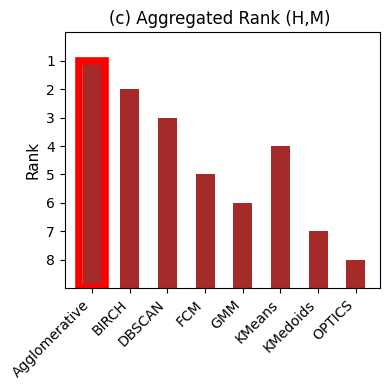

In [ ]:
#-------------------------------------------------------------------------------
# ********************* generating HM-results (4) ******************************
#-------------------------------------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt
#...................................................
file_path = "score_results/HMresult_Silhouette.txt" 
rankings,cols = parse_rankings(file_path)

dist, aggr = rankaggr_brute(rankings)

print_rankings(dist, aggr,cols)




#.....................................................
HM_Silhoute = KemenyRanking('score_results/HMresult_Silhouette.txt')
HM_DaviesBouldin = KemenyRanking('score_results/HMresult_Davies-Bouldin.txt')
HM_Calinski_Harabasz = KemenyRanking('score_results/HMresult_Calinski-Harabasz.txt')


print("HM_DaviesBouldin:", HM_DaviesBouldin)
print("HM_Calinski_Harabasz:", HM_Calinski_Harabasz)
print("HM_Silhoute:", HM_Silhoute)

with open('score_results/HM_results.txt', 'w') as f:
    f.write("Sil: " + ' '.join(["'{}'".format(method) for method in HM_Silhoute]) + "\n")
    f.write("DB: " + ' '.join(["'{}'".format(method) for method in HM_DaviesBouldin]) + "\n")
    f.write("CH: " + ' '.join(["'{}'".format(method) for method in HM_Calinski_Harabasz]) + "\n")


def plot_rankings(ax, rank_list, title, color):
    rankings = {}
    for rank, method in enumerate(rank_list, 1):
        rankings[method] = rank

    df = pd.DataFrame({
        'Combined': pd.Series(rankings)
    })

    algorithms_order = ['Agglomerative', 'BIRCH', 'DBSCAN', 'FCM', 'GMM', 'KMeans', 'KMedoids', 'OPTICS']

    visual_rank = 9 - df['Combined'].reindex(algorithms_order).fillna(9)

    bars = ax.bar(visual_rank.index, visual_rank, color=color, width=0.5)
    highest_rank_bar = df['Combined'].idxmin()

    for bar in bars:
        if 9 - bar.get_height() == 1:
            rect = plt.Rectangle((bar.get_x() - 0.1, 0), bar.get_width() + 0.2, bar.get_height(), fill=False, edgecolor='red', linewidth=5.5)
            ax.add_patch(rect)
            break

    ax.set_ylabel('Rank', fontsize=12)
    ax.set_ylim(0, 9)
    ax.set_yticks(range(1, 9))
    ax.set_yticklabels(['8', '7', '6', '5', '4', '3', '2', '1'])
    ax.set_title(title)
    ax.set_xticklabels(visual_rank.index, rotation=45, ha='right')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
plot_rankings(ax1, HM_Silhoute, '(a):Silhouette score', 'blue')
plot_rankings(ax2, HM_DaviesBouldin, '(b):Davies-Bouldin Score', 'orange')
plot_rankings(ax3, HM_Calinski_Harabasz, '(c):Calinski-Harabasz Score', 'green')

plt.tight_layout()
plt.savefig('score_results/HMresults__evauation3.png', dpi=300)
plt.show()




HM_final2 = KemenyRanking('score_results/HM_results.txt')

print("This is HM_final2", HM_final2)
HM_final0 = ', '.join([method.strip('"') for method in HM_final2])



# Split the string using comma as a separator
split_list = HM_final0.split(', ')

# Now, remove the single quotes from each element of the list
HM_final = [name.strip("'") for name in split_list]

print(HM_final[0])


print(HM_final)

# Create a dataframe for plotting
rankings = {}
for rank, method in enumerate(HM_final, 1):
    rankings[method] = rank

df = pd.DataFrame({
    'Combined': pd.Series(rankings)
})

colors = {
    'Combined': 'brown'
}

algorithms_order = ['Agglomerative', 'BIRCH', 'DBSCAN', 'FCM', 'GMM', 'KMeans', 'KMedoids', 'OPTICS']

# Reduce the width for the figsize here
fig, ax = plt.subplots(figsize=(4, 4))

visual_rank = 9 - df['Combined'].reindex(algorithms_order).fillna(9)

bars = ax.bar(visual_rank.index, visual_rank, color=colors['Combined'], width=0.5)

highest_rank_bar = df['Combined'].idxmin()

# Highlight the highest rank bar with a red rectangle
for bar in bars:
    if 9 - bar.get_height() == 1:
        rect = plt.Rectangle((bar.get_x() - 0.1, 0), bar.get_width() + 0.2, bar.get_height(), fill=False, edgecolor='red', linewidth=5.5)
        ax.add_patch(rect)
        break

ax.set_ylabel('Rank', fontsize=11)
ax.set_ylim(0, 9)
ax.set_yticks(range(1, 9))
ax.set_yticklabels(['8', '7', '6', '5', '4', '3', '2', '1'])
ax.set_title('(c) Aggregated Rank (H,M) ')
ax.set_xticklabels(visual_rank.index, rotation=45, ha='right')

plt.tight_layout()
plt.savefig('score_results/HMresults__aggregation3.png', dpi=300)
plt.show()



***Hresuts.xlsx (in 4 steps)***

In [ ]:
#-------------------------------------------------------------------------------
# ---------------------- Generating H-results (1) ----------------------------
#-------------------------------------------------------------------------------
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, OPTICS, Birch
from sklearn_extra.cluster import KMedoids
from sklearn.mixture import GaussianMixture
from fcmeans import FCM
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


files_p = ["tuning_datasets/test_1_tuning.xlsx", "tuning_datasets/test_2_tuning.xlsx", "tuning_datasets/test_3_tuning.xlsx", "tuning_datasets/test_4_tuning.xlsx"]
#files_p = processing_procedure(files)
# EXCLUDE *******************************************************
columns_to_drop = ['Depth', 'X Position', 'Y Position', 'Z Position', 'Load', 'Stiffness' , 'label' , 'MODULUS'] # please exclude those features that you dont need them
                                                                                           #First we do the expriments with Hardness alone and then Modulus Alone and then The combination of them
datasets = [pd.read_excel(file, engine='openpyxl').drop(columns_to_drop, axis=1, errors='ignore') for file in files_p]
scaled_datasets = [StandardScaler().fit_transform(df) for df in datasets]

clustering_algorithms = {
    'KMeans': KMeans(n_clusters=3, random_state=0 , init= 'k-means++' , n_init = 20 , max_iter = 100 ),

    'DBSCAN': DBSCAN(eps=0.2 , min_samples = 10),
    'Agglomerative': AgglomerativeClustering(n_clusters=3 , affinity = 'euclidean' ,  linkage = 'average'),
                     #linkage = {'ward' (default) , 'complete' , 'average' , 'single'}
                     #affinity= {'euclidean' , 'manhattan , 'cosine'}
    'OPTICS': OPTICS(min_samples = 3 , xi = 0.05),
    'KMedoids': KMedoids(n_clusters=3, random_state= 0 , init = 'random' , max_iter = 100),
                     #metric = {c , 'precomputed'}
    'GMM': GaussianMixture(n_components=3, max_iter=100 , covariance_type = 'tied'),
    'BIRCH': Birch(n_clusters=3 , branching_factor = 200 , threshold =0.1),

    'FCM': FCM(n_clusters=3 , m = 1.1)
}


metrics = {
    'Silhouette': silhouette_score,
    'Calinski-Harabasz': calinski_harabasz_score,
    'Davies-Bouldin': davies_bouldin_score
}

results = []

for index, (scaled_data, file_name) in enumerate(zip(scaled_datasets, files_p)):
    dataset_label = 'D' + str(index + 1)
    for algorithm_name, algorithm in clustering_algorithms.items():

        if algorithm_name == 'GMM':
            cluster_labels = algorithm.fit_predict(scaled_data)
        elif algorithm_name == 'FCM':
            algorithm.fit(scaled_data)
            cluster_labels = algorithm.u.argmax(axis=1)
        else:
            cluster_labels = algorithm.fit_predict(scaled_data)

        if len(set(cluster_labels)) > 1:
            for metric_name, metric_func in metrics.items():
                score = metric_func(scaled_data, cluster_labels)
                results.append({'Metric': metric_name,
                                'Dataset': dataset_label,
                                'Method': algorithm_name,
                                'Score': score})

results_df = pd.DataFrame(results)

# Reset the index to add 'Metric' and 'Dataset' as columns instead of multi-index
grouped = results_df.groupby(['Metric', 'Dataset', 'Method']).Score.mean().reset_index().pivot(index=['Metric', 'Dataset'], columns='Method', values='Score')
# Reset the multi-index and then set 'Dataset' as the new index
grouped = grouped.reset_index().set_index('Dataset')
grouped2 = grouped.reset_index().set_index('Metric')


if not os.path.exists("score_results"):
    os.mkdir("score_results")

if os.path.exists("score_results/H_results.xlsx"):
    os.remove("score_results/H_results.xlsx")

grouped.to_excel("score_results/H_results.xlsx")
print(grouped2.to_latex())




\begin{tabular}{llrrrrrrrr}
\toprule
Method & Dataset &  Agglomerative &        BIRCH &      DBSCAN &           FCM &           GMM &        KMeans &      KMedoids &     OPTICS \\
Metric            &         &                &              &             &               &               &               &               &            \\
\midrule
Calinski-Harabasz &      D1 &     556.925756 &  6870.196729 &   32.288542 &  17554.218254 &   6788.088192 &  17550.682046 &  16364.605607 &  14.316859 \\
Calinski-Harabasz &      D2 &     358.750778 &  3188.837682 &  242.546375 &  20575.461318 &  17096.505153 &  20575.343998 &  18548.078229 &  17.383679 \\
Calinski-Harabasz &      D3 &     178.638939 &  7491.833489 &  282.868131 &  23975.769164 &  21985.984074 &  23973.998863 &  21536.661352 &  19.431458 \\
Calinski-Harabasz &      D4 &    4890.695252 &  8029.446822 &  282.011739 &  16485.352598 &   6155.605933 &  16487.136700 &  14654.390029 &  21.083101 \\
Davies-Bouldin    &      D1 &       0.207

/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_8590/3902065668.py:84: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(grouped2.to_latex())


In [ ]:


#-------------------------------------------------------------------------------
#-------------------------- generating H-results (2) ---------------------------
#-------------------------------------------------------------------------------
import pandas as pd

# Step 1: Open the H_result.xlsx file
df = pd.read_excel("score_results/H_results.xlsx", engine='openpyxl')

# Clustering methods
clustering_methods = ['Agglomerative', 'BIRCH', 'DBSCAN', 'FCM', 'GMM', 'KMeans', 'KMedoids', 'OPTICS']

# Initialize an empty list to store rows and their corresponding rankings
interleaved_rows = []

for _, row in df.iterrows():
    # Append the original row first
    interleaved_rows.append(row)

    # Duplicate the row to assign rankings
    new_row = row.copy()
    new_row['Dataset'] = f"{row['Dataset']}_Ranking"

    # Depending on the metric, rank the clustering methods
    if row['Metric'] == 'Davies-Bouldin':
        rankings = row[clustering_methods].rank(ascending=True, method='first').astype(int)
    else:
        rankings = row[clustering_methods].rank(ascending=False, method='first').astype(int)

    new_row[clustering_methods] = rankings
    interleaved_rows.append(new_row)

# Convert the interleaved rows to a dataframe
rankings_df = pd.DataFrame(interleaved_rows)

# Save the updated results file
rankings_df.to_excel("score_results/H_results2.xlsx", index=False)






In [ ]:

#-------------------------------------------------------------------------------
# **************************** generating H-results (3) ***********************
#-------------------------------------------------------------------------------
import pandas as pd

results_df = pd.read_excel("score_results/H_results2.xlsx", engine='openpyxl')


clustering_methods = ['Agglomerative', 'BIRCH', 'DBSCAN', 'FCM', 'GMM', 'KMeans', 'KMedoids', 'OPTICS']


ranking_rows = results_df[results_df['Dataset'].str.contains('_Ranking', na=False)]

# Dictionary to store ordered methods for each metric
ordered_methods_dict = {}

for metric in ranking_rows['Metric'].unique():
    metric_subset = ranking_rows[ranking_rows['Metric'] == metric]

    # Extract ranking order for each Dataset within the metric
    for _, row in metric_subset.iterrows():

        # Order clustering methods by their rank
        ordered_methods = [clustering_methods[i] for i in row[clustering_methods].argsort()]


        if metric in ordered_methods_dict:
            ordered_methods_dict[metric].append({row['Dataset']: ordered_methods})
        else:
            ordered_methods_dict[metric] = [{row['Dataset']: ordered_methods}]

for metric, datasets_order in ordered_methods_dict.items():
    with open(f"score_results/H_result_{metric}.txt", 'w') as f:
        for order in datasets_order:
            dataset_name = list(order.keys())[0]
            
            # Add double quotes around each method name
            methods_order = ' '.join(['"' + method + '"' for method in order[dataset_name]])
            
            f.write(f"{dataset_name}: {methods_order}\n")


# This give us an Aggregated_Ranking_Order across 4 datasets for each dataset /
# In the following we will plot the Barcharts based on the result of each Metrics



H_DaviesBouldin: ['Agglomerative', 'BIRCH', 'GMM', 'KMeans', 'FCM', 'KMedoids', 'DBSCAN', 'OPTICS']
H_Calinski_Harabasz: ['FCM', 'KMeans', 'KMedoids', 'BIRCH', 'GMM', 'Agglomerative', 'DBSCAN', 'OPTICS']
H_Silhoute: ['DBSCAN', 'Agglomerative', 'BIRCH', 'FCM', 'KMeans', 'KMedoids', 'GMM', 'OPTICS']


/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_8590/834510186.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(visual_rank.index, rotation=45, ha='right')
/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_8590/834510186.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(visual_rank.index, rotation=45, ha='right')
/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_8590/834510186.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(visual_rank.index, rotation=45, ha='right')


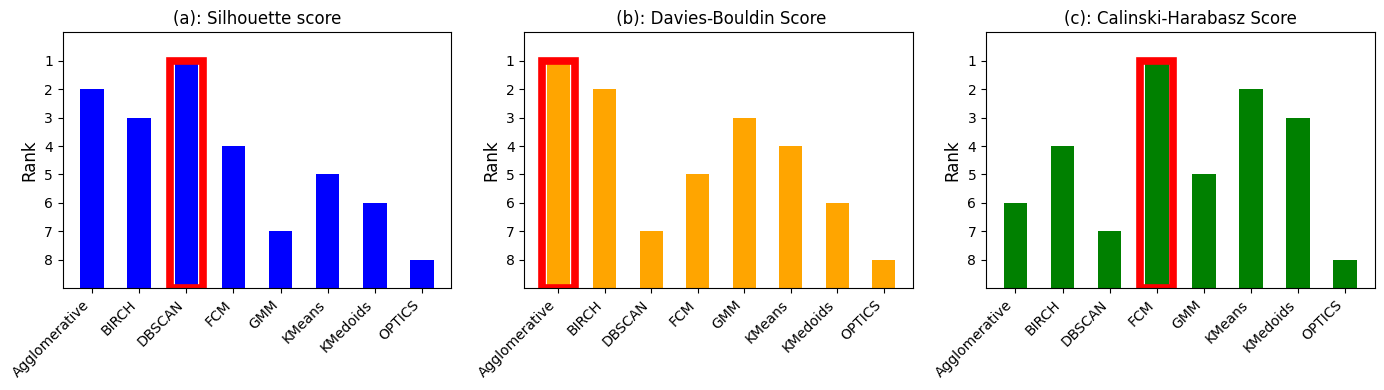

This is ['GMM', 'DBSCAN', 'Agglomerative', 'FCM', 'BIRCH', 'KMeans', 'KMedoids', 'OPTICS']
GMM
This is H_final : 
  
['GMM', 'DBSCAN', 'Agglomerative', 'FCM', 'BIRCH', 'KMeans', 'KMedoids', 'OPTICS']


/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_8590/834510186.py:120: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(visual_rank.index, rotation=45, ha='right')


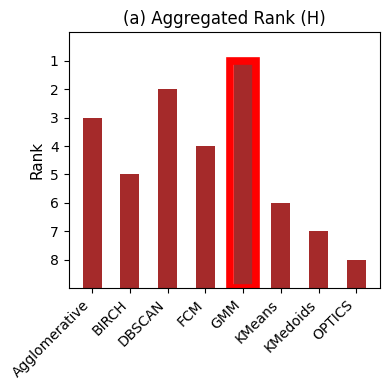

In [ ]:

#-------------------------------------------------------------------------------
# ** generating H-results (4) **
#-------------------------------------------------------------------------------


import pandas as pd
import matplotlib.pyplot as plt


H_Silhoute = KemenyRanking('score_results/H_result_Silhouette.txt')
H_DaviesBouldin = KemenyRanking('score_results/H_result_Davies-Bouldin.txt')
H_Calinski_Harabasz = KemenyRanking('score_results/H_result_Calinski-Harabasz.txt')


print("H_DaviesBouldin:", H_DaviesBouldin)
print("H_Calinski_Harabasz:", H_Calinski_Harabasz)
print("H_Silhoute:", H_Silhoute)

with open('score_results/H_results.txt', 'w') as f:
    f.write("Sil: " + ' '.join(["'{}'".format(method) for method in H_Silhoute]) + "\n")
    f.write("DB: " + ' '.join(["'{}'".format(method) for method in H_DaviesBouldin]) + "\n")
    f.write("CH: " + ' '.join(["'{}'".format(method) for method in H_Calinski_Harabasz]) + "\n")


def plot_rankings(ax, rank_list, title, color):
    rankings = {}
    for rank, method in enumerate(rank_list, 1):
        rankings[method] = rank

    df = pd.DataFrame({
        'Combined': pd.Series(rankings)
    })

    algorithms_order = ['Agglomerative', 'BIRCH', 'DBSCAN', 'FCM', 'GMM', 'KMeans', 'KMedoids', 'OPTICS']

    visual_rank = 9 - df['Combined'].reindex(algorithms_order).fillna(9)

    bars = ax.bar(visual_rank.index, visual_rank, color=color, width=0.5)
    highest_rank_bar = df['Combined'].idxmin()

    for bar in bars:
        if 9 - bar.get_height() == 1:
            rect = plt.Rectangle((bar.get_x() - 0.1, 0), bar.get_width() + 0.2, bar.get_height(), fill=False, edgecolor='red', linewidth=5.5)
            ax.add_patch(rect)
            break

    ax.set_ylabel('Rank', fontsize=12)
    ax.set_ylim(0, 9)
    ax.set_yticks(range(1, 9))
    ax.set_yticklabels(['8', '7', '6', '5', '4', '3', '2', '1'])
    ax.set_title(title)
    ax.set_xticklabels(visual_rank.index, rotation=45, ha='right')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
plot_rankings(ax1, H_Silhoute, '(a): Silhouette score', 'blue')
plot_rankings(ax2, H_DaviesBouldin,' (b): Davies-Bouldin Score', 'orange')
plot_rankings(ax3, H_Calinski_Harabasz, '(c): Calinski-Harabasz Score', 'green')

plt.tight_layout()
plt.savefig('score_results/Hresults__evauation3.png', dpi=300)
plt.show()




H_final2 = KemenyRanking('score_results/H_results.txt')

print("This is", H_final2)
H_final0 = ', '.join([method.strip('"') for method in H_final2])



# Split the string using comma as a separator
split_list = H_final0.split(', ')

# Now, remove the single quotes from each element of the list
H_final = [name.strip("'") for name in split_list]

print(H_final[0])

print("This is H_final : \n  ")
print(H_final)

# Create a dataframe for plotting
rankings = {}
for rank, method in enumerate(H_final, 1):
    rankings[method] = rank

df = pd.DataFrame({
    'Combined': pd.Series(rankings)
})

colors = {
    'Combined': 'brown'
}

algorithms_order = ['Agglomerative', 'BIRCH', 'DBSCAN', 'FCM', 'GMM', 'KMeans', 'KMedoids', 'OPTICS']

# Reduce the width for the figsize here
fig, ax = plt.subplots(figsize=(4, 4))

visual_rank = 9 - df['Combined'].reindex(algorithms_order).fillna(9)

bars = ax.bar(visual_rank.index, visual_rank, color=colors['Combined'], width=0.5)

highest_rank_bar = df['Combined'].idxmin()

# Highlight the highest rank bar with a red rectangle
for bar in bars:
    if 9 - bar.get_height() == 1:
        rect = plt.Rectangle((bar.get_x() - 0.1, 0), bar.get_width() + 0.2, bar.get_height(), fill=False, edgecolor='red', linewidth=5.5)
        ax.add_patch(rect)
        break

ax.set_ylabel('Rank', fontsize=11)
ax.set_ylim(0, 9)
ax.set_yticks(range(1, 9))
ax.set_yticklabels(['8', '7', '6', '5', '4', '3', '2', '1'])
ax.set_title('(a) Aggregated Rank (H)')
ax.set_xticklabels(visual_rank.index, rotation=45, ha='right')

plt.tight_layout()
plt.savefig('score_results/Hresults__aggregation3.png', dpi=300)
plt.show()



Mresults.xlsx (in 4 steps)

In [ ]:
#-------------------------------------------------------------------------------
# ******************** Generating M-results (1) *******************************
#-------------------------------------------------------------------------------

import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, OPTICS, Birch
from sklearn_extra.cluster import KMedoids
from sklearn.mixture import GaussianMixture
from fcmeans import FCM
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


files_p = ["tuning_datasets/test_1_tuning.xlsx", "tuning_datasets/test_2_tuning.xlsx", "tuning_datasets/test_3_tuning.xlsx", "tuning_datasets/test_4_tuning.xlsx"]
#files_p = processing_procedure(files)
# EXCLUDE *******************************************************
columns_to_drop = ['Depth', 'X Position', 'Y Position', 'Z Position', 'Load', 'Stiffness' , 'label' , 'HARDNESS'] # please exclude those features that you dont need them
                                                                                           #First we do the expriments with Hardness alone and then Modulus Alone and then The combination of them
datasets = [pd.read_excel(file, engine='openpyxl').drop(columns_to_drop, axis=1, errors='ignore') for file in files_p]
scaled_datasets = [StandardScaler().fit_transform(df) for df in datasets]

clustering_algorithms = {
    'KMeans': KMeans(n_clusters=3, random_state=0 , init= 'k-means++' , n_init = 20 , max_iter = 100 ),

    'DBSCAN': DBSCAN(eps=0.2 , min_samples = 10),
    'Agglomerative': AgglomerativeClustering(n_clusters=3 , affinity = 'euclidean' ,  linkage = 'average'),
                     #linkage = {'ward' (default) , 'complete' , 'average' , 'single'}
                     #affinity= {'euclidean' , 'manhattan , 'cosine'}
    'OPTICS': OPTICS(min_samples = 3 , xi = 0.05),
    'KMedoids': KMedoids(n_clusters=3, random_state= 0 , init = 'random' , max_iter = 100),
                     #metric = {c , 'precomputed'}
    'GMM': GaussianMixture(n_components=3, max_iter=100 , covariance_type = 'tied'),
    'BIRCH': Birch(n_clusters=3 , branching_factor = 200 , threshold =0.1),

    'FCM': FCM(n_clusters=3 , m = 1.1)
}


metrics = {
    'Silhouette': silhouette_score,
    'Calinski-Harabasz': calinski_harabasz_score,
    'Davies-Bouldin': davies_bouldin_score
}

results = []

for index, (scaled_data, file_name) in enumerate(zip(scaled_datasets, files_p)):
    dataset_label = 'D' + str(index + 1)
    for algorithm_name, algorithm in clustering_algorithms.items():

        if algorithm_name == 'GMM':
            cluster_labels = algorithm.fit_predict(scaled_data)
        elif algorithm_name == 'FCM':
            algorithm.fit(scaled_data)
            cluster_labels = algorithm.u.argmax(axis=1)
        else:
            cluster_labels = algorithm.fit_predict(scaled_data)

        if len(set(cluster_labels)) > 1:
            for metric_name, metric_func in metrics.items():
                score = metric_func(scaled_data, cluster_labels)
                results.append({'Metric': metric_name,
                                'Dataset': dataset_label,
                                'Method': algorithm_name,
                                'Score': score})

results_df = pd.DataFrame(results)

# Reset the index to add 'Metric' and 'Dataset' as columns instead of multi-index
grouped = results_df.groupby(['Metric', 'Dataset', 'Method']).Score.mean().reset_index().pivot(index=['Metric', 'Dataset'], columns='Method', values='Score')
# Reset the multi-index and then set 'Dataset' as the new index
grouped = grouped.reset_index().set_index('Dataset')

if not os.path.exists("score_results"):
    os.mkdir("score_results")


if os.path.exists("score_results/M_results.xlsx"):
    os.remove("score_results/M_results.xlsx")

grouped.to_excel("score_results/M_results.xlsx")
print(grouped.to_latex())


\begin{tabular}{llrrrrrrrr}
\toprule
Method &             Metric &  Agglomerative &         BIRCH &      DBSCAN &           FCM &           GMM &        KMeans &      KMedoids &     OPTICS \\
Dataset &                    &                &               &             &               &               &               &               &            \\
\midrule
D1      &  Calinski-Harabasz &     231.092640 &   9258.034544 &  182.109926 &  18366.779761 &   2921.240456 &  18366.909188 &  17093.305011 &  17.736525 \\
D2      &  Calinski-Harabasz &     311.672440 &   2170.389714 &   20.903852 &  15871.237971 &   2643.164601 &  15871.196172 &  14792.024857 &  19.813960 \\
D3      &  Calinski-Harabasz &     601.678079 &  14196.037240 &   59.481555 &  22988.183575 &  10904.142514 &  22982.925722 &  22146.063254 &  23.161699 \\
D4      &  Calinski-Harabasz &    2614.386480 &   2694.157375 &  815.248058 &  14909.109533 &  12900.286425 &  14908.680169 &  12587.837437 &  22.319200 \\
D1      &     Davie

/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_8590/798785132.py:84: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(grouped.to_latex())


In [ ]:
#-------------------------------------------------------------------------------
# ** generating M-results (2) **
#-------------------------------------------------------------------------------
import pandas as pd

# Step 1: Open the HMresult.xlsx file
df = pd.read_excel("score_results/M_results.xlsx", engine='openpyxl')

# Clustering methods
clustering_methods = ['Agglomerative', 'BIRCH', 'DBSCAN', 'FCM', 'GMM', 'KMeans', 'KMedoids', 'OPTICS']

# Initialize an empty list to store rows and their corresponding rankings
interleaved_rows = []

for _, row in df.iterrows():
    # Append the original row first
    interleaved_rows.append(row)

    # Duplicate the row to assign rankings
    new_row = row.copy()
    new_row['Dataset'] = f"{row['Dataset']}_Ranking"

    # Depending on the metric, rank the clustering methods
    if row['Metric'] == 'Davies-Bouldin':
        rankings = row[clustering_methods].rank(ascending=True, method='first').astype(int)
    else:
        rankings = row[clustering_methods].rank(ascending=False, method='first').astype(int)

    new_row[clustering_methods] = rankings
    interleaved_rows.append(new_row)

# Convert the interleaved rows to a dataframe
rankings_df = pd.DataFrame(interleaved_rows)

# Save the updated results file
rankings_df.to_excel("score_results/M_results2.xlsx", index=False)




In [ ]:
#-------------------------------------------------------------------------------
# ******************** generating M-results (3) ******************************
#-------------------------------------------------------------------------------

import pandas as pd

results_df = pd.read_excel("score_results/M_results2.xlsx", engine='openpyxl')


clustering_methods = ['Agglomerative', 'BIRCH', 'DBSCAN', 'FCM', 'GMM', 'KMeans', 'KMedoids', 'OPTICS']


ranking_rows = results_df[results_df['Dataset'].str.contains('_Ranking', na=False)]

# Dictionary to store ordered methods for each metric
ordered_methods_dict = {}

for metric in ranking_rows['Metric'].unique():
    metric_subset = ranking_rows[ranking_rows['Metric'] == metric]

    # Extract ranking order for each Dataset within the metric
    for _, row in metric_subset.iterrows():

        # Order clustering methods by their rank
        ordered_methods = [clustering_methods[i] for i in row[clustering_methods].argsort()]


        if metric in ordered_methods_dict:
            ordered_methods_dict[metric].append({row['Dataset']: ordered_methods})
        else:
            ordered_methods_dict[metric] = [{row['Dataset']: ordered_methods}]

#write to TXT file
for metric, datasets_order in ordered_methods_dict.items():
    with open(f"score_results/M_result_{metric}.txt", 'w') as f:
        for order in datasets_order:
            dataset_name = list(order.keys())[0]
            
            # Add double quotes around each method name
            methods_order = ' '.join(['"' + method + '"' for method in order[dataset_name]])
            
            f.write(f"{dataset_name}: {methods_order}\n")




# This give us an Aggregated_Ranking_Order across 4 datasets for each dataset /
# In the following we will plot the Barcharts based on the result of each Metric

M_DaviesBouldin: ['Agglomerative', 'BIRCH', 'GMM', 'KMeans', 'FCM', 'KMedoids', 'DBSCAN', 'OPTICS']
M_Calinski_Harabasz: ['FCM', 'KMeans', 'KMedoids', 'BIRCH', 'GMM', 'Agglomerative', 'DBSCAN', 'OPTICS']
M_Silhoute: ['Agglomerative', 'DBSCAN', 'BIRCH', 'FCM', 'KMeans', 'KMedoids', 'GMM', 'OPTICS']


/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_8590/2475735749.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(visual_rank.index, rotation=45, ha='right')
/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_8590/2475735749.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(visual_rank.index, rotation=45, ha='right')
/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_8590/2475735749.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(visual_rank.index, rotation=45, ha='right')


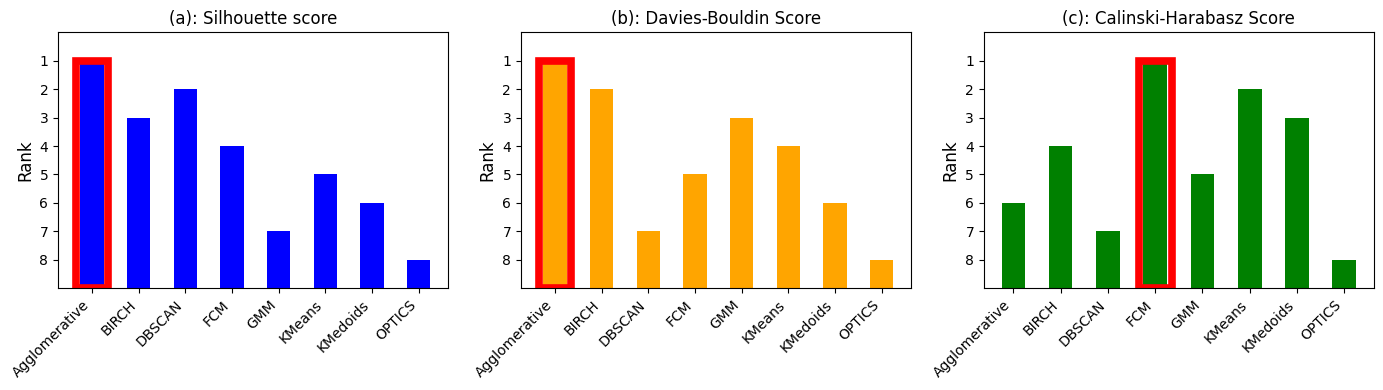

This is M_final2 ['Agglomerative', 'GMM', 'DBSCAN', 'FCM', 'BIRCH', 'KMeans', 'KMedoids', 'OPTICS']
Agglomerative
['Agglomerative', 'GMM', 'DBSCAN', 'FCM', 'BIRCH', 'KMeans', 'KMedoids', 'OPTICS']


/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_8590/2475735749.py:119: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(visual_rank.index, rotation=45, ha='right')


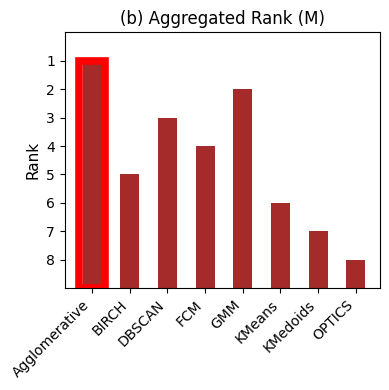

In [236]:
#-------------------------------------------------------------------------------
# ** generating M-results (4) **
#-------------------------------------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt


M_Silhoute = KemenyRanking('score_results/M_result_Silhouette.txt')
M_DaviesBouldin = KemenyRanking('score_results/M_result_Davies-Bouldin.txt')
M_Calinski_Harabasz = KemenyRanking('score_results/M_result_Calinski-Harabasz.txt')


print("M_DaviesBouldin:", M_DaviesBouldin)
print("M_Calinski_Harabasz:", M_Calinski_Harabasz)
print("M_Silhoute:", M_Silhoute)

with open('score_results/M_results.txt', 'w') as f:
    f.write("Sil: " + ' '.join(["'{}'".format(method) for method in M_Silhoute]) + "\n")
    f.write("DB: " + ' '.join(["'{}'".format(method) for method in M_DaviesBouldin]) + "\n")
    f.write("CH: " + ' '.join(["'{}'".format(method) for method in M_Calinski_Harabasz]) + "\n")


def plot_rankings(ax, rank_list, title, color):
    rankings = {}
    for rank, method in enumerate(rank_list, 1):
        rankings[method] = rank

    df = pd.DataFrame({
        'Combined': pd.Series(rankings)
    })

    algorithms_order = ['Agglomerative', 'BIRCH', 'DBSCAN', 'FCM', 'GMM', 'KMeans', 'KMedoids', 'OPTICS']

    visual_rank = 9 - df['Combined'].reindex(algorithms_order).fillna(9)

    bars = ax.bar(visual_rank.index, visual_rank, color=color, width=0.5)
    highest_rank_bar = df['Combined'].idxmin()

    for bar in bars:
        if 9 - bar.get_height() == 1:
            rect = plt.Rectangle((bar.get_x() - 0.1, 0), bar.get_width() + 0.2, bar.get_height(), fill=False, edgecolor='red', linewidth=5.5)
            ax.add_patch(rect)
            break

    ax.set_ylabel('Rank', fontsize=12)
    ax.set_ylim(0, 9)
    ax.set_yticks(range(1, 9))
    ax.set_yticklabels(['8', '7', '6', '5', '4', '3', '2', '1'])
    ax.set_title(title)
    ax.set_xticklabels(visual_rank.index, rotation=45, ha='right')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
plot_rankings(ax1, M_Silhoute, '(a): Silhouette score', 'blue')
plot_rankings(ax2, M_DaviesBouldin, '(b): Davies-Bouldin Score', 'orange')
plot_rankings(ax3, M_Calinski_Harabasz, '(c): Calinski-Harabasz Score', 'green')

plt.tight_layout()
plt.savefig('score_results/Mresults__evauation3.png', dpi=300)
plt.show()




M_final2 = KemenyRanking('score_results/M_results.txt')

print("This is M_final2", M_final2)
M_final0 = ', '.join([method.strip('"') for method in M_final2])



# Split the string using comma as a separator
split_list = M_final0.split(', ')

# Now, remove the single quotes from each element of the list
M_final = [name.strip("'") for name in split_list]

print(M_final[0])


print(M_final)

# Create a dataframe for plotting
rankings = {}
for rank, method in enumerate(M_final, 1):
    rankings[method] = rank

df = pd.DataFrame({
    'Combined': pd.Series(rankings)
})

colors = {
    'Combined': 'brown'
}

algorithms_order = ['Agglomerative', 'BIRCH', 'DBSCAN', 'FCM', 'GMM', 'KMeans', 'KMedoids', 'OPTICS']

# Reduce the width for the figsize here
fig, ax = plt.subplots(figsize=(4, 4))

visual_rank = 9 - df['Combined'].reindex(algorithms_order).fillna(9)

bars = ax.bar(visual_rank.index, visual_rank, color=colors['Combined'], width=0.5)

highest_rank_bar = df['Combined'].idxmin()

# Highlight the highest rank bar with a red rectangle
for bar in bars:
    if 9 - bar.get_height() == 1:
        rect = plt.Rectangle((bar.get_x() - 0.1, 0), bar.get_width() + 0.2, bar.get_height(), fill=False, edgecolor='red', linewidth=5.5)
        ax.add_patch(rect)
        break

ax.set_ylabel('Rank', fontsize=11)
ax.set_ylim(0, 9)
ax.set_yticks(range(1, 9))
ax.set_yticklabels(['8', '7', '6', '5', '4', '3', '2', '1'])
ax.set_title('(b) Aggregated Rank (M)')
ax.set_xticklabels(visual_rank.index, rotation=45, ha='right')

plt.tight_layout()
plt.savefig('score_results/Mresults__aggregation3.png', dpi=300)
plt.show()


In [220]:
from __future__ import division
from timeit import default_timer as time
from cylp.cy import CyClpSimplex
import itertools
import numpy as np
import scipy.sparse as sp

def extended_condorcet_simple(rankings):
    n = rankings.shape[1]
    pairs = combs(range(n), 2)
    condorcet_rows, condorcet_cols = [], []

    for cand, other_cand in pairs:
        cand_pos = np.where(rankings == cand)[1]
        other_pos = np.where(rankings == other_cand)[1]

        if np.all(cand_pos < other_pos):
            condorcet_rows.append(cand)
            condorcet_cols.append(other_cand)
        elif np.all(other_pos < cand_pos):
            condorcet_rows.append(other_cand)
            condorcet_cols.append(cand)

    mat = sp.coo_matrix((np.ones(len(condorcet_rows)), (condorcet_rows, condorcet_cols)))
    return mat

def combs(a, r):
    a = np.asarray(a)
    dt = np.dtype([('', a.dtype)] * r)
    b = np.fromiter(itertools.combinations(a, r), dt)
    return b.view(a.dtype).reshape(-1, r)

def perms(a, r):
    a = np.asarray(a)
    dt = np.dtype([('', a.dtype)] * r)
    b = np.fromiter(itertools.permutations(a, r), dt)
    return b.view(a.dtype).reshape(-1, r)

class KemenyRanking2():
    def __init__(self, fp, verbose=True, condorcet_red=True):
        self.verbose = verbose
        self.condorcet_red = True
        self.parse_file(fp)

    def parse_file(self, fp):
        if self.verbose:
            print('Parse input')

        with open(fp) as file:
            content = file.readlines()
            content = [x.strip() for x in content]
            content = [x.replace(':', '') for x in content]
            content = [np.array(x.split(), dtype=object) for x in content]

            raw_arr = np.array(content)
            self.voters_raw = raw_arr[:, 0]
            self.votes_raw = raw_arr[:, 1:]

            self.orig2id = {}
            self.id2orig = {}
            id_ = 0
            for i in np.unique(self.votes_raw):
                self.orig2id[i] = id_
                self.id2orig[id_] = i
                id_ += 1
            self.votes_arr = np.vectorize(self.orig2id.get)(self.votes_raw)

        if self.verbose:
            print('     ... finished')
            print('Problem statistics')
            print('  {} votes'.format(self.votes_arr.shape[0]))
            print('  {} candidates'.format(self.votes_arr.shape[1]))

    def build_Q(self):
        if self.verbose:
            print('Build incidence-matrix')

        N, n = self.votes_arr.shape
        self.Q = np.zeros((n, n))
        for a, b in itertools.combinations(range(n), 2):
            a_pos = np.where(self.votes_arr == a)[1]
            b_pos = np.where(self.votes_arr == b)[1]
            plus = np.count_nonzero(a_pos < b_pos)
            minus = np.count_nonzero(a_pos > b_pos)
            self.Q[a, b] = plus
            self.Q[b, a] = minus

        if self.verbose:
            print('     ... finished')

    def solve_ilp(self):
        if self.verbose:
            print('Solve: build model')

        if self.condorcet_red:
            condorcet_red_mat = extended_condorcet_simple(self.votes_arr)

        n = self.Q.shape[0]
        x_n = n * n

        model = CyClpSimplex()
        x = model.addVariable('x', x_n, isInt=True)
        model.objective = self.Q.ravel()

        model += sp.eye(x_n) * x >= np.zeros(x_n)
        model += sp.eye(x_n) * x <= np.ones(x_n)

        idx = lambda i, j: np.ravel_multi_index((i, j), (n, n))
        start_time = time()
        n_pairwise_constr = n * (n - 1) // 2

        if self.verbose:
            print('  # pairwise constr: ', n_pairwise_constr)

        combs_ = combs(range(n), 2)
        inds_a = np.ravel_multi_index(combs_.T, (n, n))
        inds_b = np.ravel_multi_index(combs_.T[::-1], (n, n))

        row_inds = np.tile(np.arange(n_pairwise_constr), 2)
        col_inds = np.hstack((inds_a, inds_b))

        pairwise_constraints = sp.coo_matrix((np.ones(n_pairwise_constr * 2),
                                              (row_inds, col_inds)),
                                             shape=(n_pairwise_constr, n * n))

        end_time = time()
        if self.verbose:
            print("    Took {:.{prec}f} secs".format(end_time - start_time, prec=3))

        start_time = time()
        n_triangle_constrs = n * (n - 1) * (n - 2)

        if self.verbose:
            print('  # triangle constr: ', n_triangle_constrs)

        perms_ = perms(range(n), 3)

        inds_a = np.ravel_multi_index(perms_.T[(0, 1), :], (n, n))
        inds_b = np.ravel_multi_index(perms_.T[(1, 2), :], (n, n))
        inds_c = np.ravel_multi_index(perms_.T[(2, 0), :], (n, n))

        row_inds = np.tile(np.arange(n_triangle_constrs), 3)
        col_inds = np.hstack((inds_a, inds_b, inds_c))

        triangle_constraints = sp.coo_matrix((np.ones(n_triangle_constrs * 3),
                                              (row_inds, col_inds)),
                                             shape=(n_triangle_constrs, n * n))

        end_time = time()
        if self.verbose:
            print("    Took {:.{prec}f} secs".format(end_time - start_time, prec=3))

        model += pairwise_constraints * x == np.ones(n_pairwise_constr)
        model += triangle_constraints * x >= np.ones(n_triangle_constrs)

        if self.condorcet_red:
            I, J, V = sp.find(condorcet_red_mat)
            indices_pos = np.ravel_multi_index([J, I], (n, n))
            indices_neg = np.ravel_multi_index([I, J], (n, n))
            nnz = len(indices_pos)

            if self.verbose:
                print('  Extended Condorcet reductions: {} * 2 relations fixed'.format(nnz))

            lhs = sp.coo_matrix((np.ones(nnz * 2),
                                 (np.arange(nnz * 2),
                                  np.hstack((indices_pos, indices_neg)))),
                                shape=(nnz * 2, n * n))
            rhs = np.hstack((np.ones(len(indices_pos)), np.zeros(len(indices_neg))))
            model += lhs * x == rhs

        cbcModel = model.getCbcModel()
        cbcModel.logLevel = self.verbose

        if self.verbose:
            print('Solve: run MIP\n')
        start_time = time()
        status = cbcModel.solve()
        end_time = time()
        if self.verbose:
            print("  CoinOR CBC used {:.{prec}f} secs".format(end_time - start_time, prec=3))

        x_sol = cbcModel.primalVariableSolution['x']
        self.obj_sol = cbcModel.objectiveValue
        x = np.array(x_sol).reshape((n, n)).round().astype(int)
        self.aggr_rank = np.argsort(x.sum(axis=0))[::-1]

    def postprocess(self):
        if self.verbose:
           print('Postprocessing')
        self.final_solution = np.vectorize(self.id2orig.get)(self.aggr_rank)
        self.final_solution = np.char.replace(self.final_solution, "'", "")  # Remove single quotes
        if self.verbose:
            print('    ... finished')


    def compute_solution(self):
        self.build_Q()
        self.solve_ilp()
        self.postprocess()
        return self.final_solution



In [221]:
#kr_instance = KemenyRanking2('score_results/M_results.txt')
#solution = kr_instance.compute_solution()
#print(solution)


print(KemenyRanking2('score_results/M_results.txt').compute_solution())









Parse input
     ... finished
Problem statistics
  3 votes
  8 candidates
Build incidence-matrix
     ... finished
Solve: build model
  # pairwise constr:  28
    Took 0.000 secs
  # triangle constr:  336
    Took 0.000 secs
  Extended Condorcet reductions: 11 * 2 relations fixed
Solve: run MIP

  CoinOR CBC used 0.004 secs
Postprocessing
    ... finished
['Agglomerative' 'BIRCH' 'FCM' 'KMeans' 'KMedoids' 'GMM' 'DBSCAN' 'OPTICS']
Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Mar 26 2022 

command line - ICbcModel -solve -quit (default strategy 1)
Continuous objective value is 17 - 0.00 seconds
Cgl0004I processed model has 50 rows, 17 columns (17 integer (17 of which binary)) and 132 elements
Cbc0012I Integer solution of 17 found by DiveCoefficient after 0 iterations and 0 nodes (0.00 seconds)
Cbc0001I Search completed - best objective 17, took 0 iterations and 0 nodes (0.00 seconds)
Cbc0035I Maximum depth 0, 0 variables fixed on reduced cost
Cuts at root node changed obj

Kenemy Method for Aggregation

Final_result :  ['Agglomerative', 'DBSCAN', 'GMM', 'FCM', 'BIRCH', 'KMeans', 'KMedoids', 'OPTICS']
Ranked Methods Dict: {'Agglomerative': 1, 'DBSCAN': 2, 'GMM': 3, 'FCM': 4, 'BIRCH': 5, 'KMeans': 6, 'KMedoids': 7, 'OPTICS': 8}


/var/folders/mj/qg7tq91j0l58tyg_xx80dwwc0000gn/T/ipykernel_8590/1683857742.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(visual_rank.index, rotation=45, ha='right')


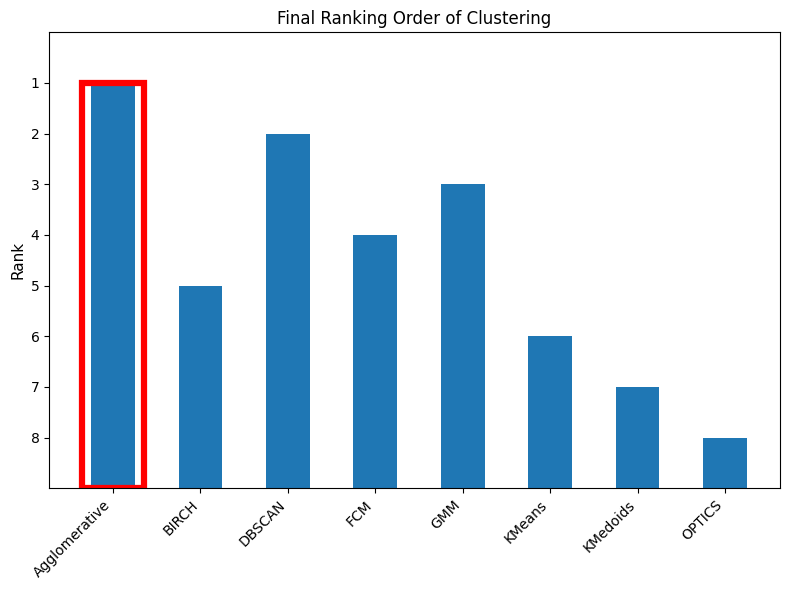

In [238]:
#---------------------------------------------------------
#------------FINAL RESULT OF THE EXPRIMENT----------------
#--------------FINAL RANKING WITH KEMENY------------------
#----------------------------------------------------------


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

with open("score_results/final_final_aggregated.txt", "w") as file:
    file.write("M_final: " + ' '.join(f'"{algorithm}"' for algorithm in M_final) + "\n")
    file.write("H_final: " + ' '.join(f'"{algorithm}"' for algorithm in H_final) + "\n")
    file.write("HM_final: " + ' '.join(f'"{algorithm}"' for algorithm in HM_final) + "\n")


clustering_methods = ['Agglomerative', 'BIRCH', 'DBSCAN', 'FCM', 'GMM', 'KMeans', 'KMedoids', 'OPTICS']    

# Get final results from Kemeny ranking
final_results = KemenyRanking("score_results/final_final_aggregated.txt")
final_results = [algorithm.replace(',', '') for algorithm in final_results]
print("Final_result : " , final_results)


ranked_methods_dict = {method: rank for rank, method in enumerate(final_results, 1)}
print("Ranked Methods Dict:", ranked_methods_dict)

fig, ax = plt.subplots(figsize=(8, 6))


visual_rank = 9 - pd.Series(ranked_methods_dict).reindex(clustering_methods).fillna(9)

bars = ax.bar(visual_rank.index, visual_rank, width=0.5)


highest_rank_method = max(ranked_methods_dict, key=ranked_methods_dict.get)


for bar in bars:
    if bar.get_height() == 8:  # Because rank 1 visually appears as height 8
        rect = plt.Rectangle((bar.get_x() - 0.1, 0), bar.get_width() + 0.2, bar.get_height(), fill=False, edgecolor='red', linewidth=4.5)
        ax.add_patch(rect)
        break

ax.set_ylabel('Rank', fontsize=11)
ax.set_ylim(0, 9)
ax.set_yticks(range(1, 9))
ax.set_yticklabels(['8', '7', '6', '5', '4', '3', '2', '1'])
ax.set_title('Final Ranking Order of Clustering')
ax.set_xticklabels(visual_rank.index, rotation=45, ha='right')

plt.tight_layout()
plt.savefig('score_results/final_results_evaluation.png', dpi=300)
plt.show()